In [6]:
import h5py as h5
import skimage as sk
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import os
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects
import random
import pygalmesh

In [10]:
path_chip='Chip_crop_byhand/'
path_gel='Expanded_Gel_crop/'

gels=[path_gel+el for el in os.listdir(path_gel) if 'mask' in el]
chips=[path_chip+el for el in os.listdir(path_chip) if 'mask' in el]
gels=sorted(gels)
chips=sorted(chips)



## Sample images we are trying to find the deformation field for

Text(0.5, 1.0, 'Expanded Gel mask')

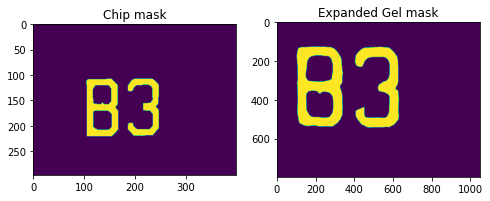

In [25]:
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(imread(chips[13])[:,:,3]>125)
ax[1].imshow(imread(gels[13])[::-1,::-1,3]>110)
ax[0].set_title('Chip mask')
ax[1].set_title('Expanded Gel mask')

In [9]:
class Data:
    def __init__(self,gels,chips):
        '''Takes sorted lists of (string) paths to gel masks, and chip masks
        Assumes a structure wherein the letter/number combination can be found by calling
        path.split('_')[-6] (meaning the number letter is contained in a name at a specific position between
        two underscores, in this case in the chips filename)
        '''
        self.gels=gels
        self.chips=chips
    def create_aligned_contours(self,idx,chiptresh=120,geltresh=125):
        self.img_idx=idx
        
        chip=imread(self.chips[idx])[:,:,3]>chiptresh
        
        gel=imread(self.gels[idx])[:,:,3]>geltresh #label is in alpha channel.
        pattern=self.chips[idx].split('_')[-6] #'A1, A2, etc"
        self.pattern=pattern
        ##Clean up chip
        sizes=np.sort([r.area for r in regionprops(label(chip))])[::-1]
        #kill all areas smaller than the number of areas we want to segment
        cut_off_size=sizes[len(pattern)-1]-5 #-5 for some room for error, remove_small_object is bit too aggressive
        clean_chip=remove_small_objects(chip,cut_off_size)

        ##Clean up gel
        sizes=np.sort([r.area for r in regionprops(label(gel))])[::-1]
        #kill all areas smaller than the number of areas we want to segment
        cut_off_size=sizes[len(pattern)-1]-5 #-5 for some room for error, remove_small_object is bit too aggressive
        clean_gel=remove_small_objects(gel,cut_off_size)

        #mirror images upright

        self.clean_gel=clean_gel[::-1,::-1]
        self.clean_chip=clean_chip[::-1,:]
        
        #pad it so that if object touches image edge, contour is still traced.
        contour_gel=sk.measure.find_contours(np.pad(self.clean_gel,[1,1]),level=0.9) #mask pixel is=1, so 0.9 is safe
        contour_chip=sk.measure.find_contours(np.pad(self.clean_chip,[1,1]),level=0.9)
        
        #there will be small impurities inside letters, creating small paths. We weed those out
        smallest_path=50 #datapoints
        contour_gel=[c for c in contour_gel if len(c)>smallest_path]
        contour_chip=[c for c in contour_chip if len(c)>smallest_path]

        
        
        #find the centers to pre-align and then scale the contours to help
        #the diffeomorphic metric mapping match-deform contours. Too large discrepancies
        #are not ideal to handle, although the algorithm could still converge
        #once the deformation is found, we'll reinstatiate the shift+scaling to
        #match it back to the original images and resolutions.
        self.center_gel_xy=np.mean(np.concatenate(contour_gel),axis=0)
        self.center_chip_xy=np.mean(np.concatenate(contour_chip),axis=0)

        #get the scale and normalize
        def span(x):
            return np.max(x,axis=0)-np.min(x,axis=0)
        self.scale_gel_x,scale_gel_y=span(np.concatenate(contour_gel))
        self.scale_chip_x,scale_chip_y=span(np.concatenate(contour_chip))

        #scale by just one factor, let's choose x for now. otherwise shapes are deformed
        #differently. maybe ok, maybe not.
        self.contour_gel=[(p-self.center_gel_xy)/np.array([self.scale_gel_x,self.scale_gel_x]) for p in contour_gel]
        self.contour_chip=[(p-self.center_chip_xy)/np.array([self.scale_chip_x,self.scale_chip_x]) for p in contour_chip]
        return self.contour_gel,self.contour_chip
    
    def construct_chip_mesh(self,decimate_contour=2,triangle_size=0.02):
        '''This calls pygalmesh and constructs a triangulated mesh of the chip (unexpanded gel).
        The triangulation will help estimate local deformations of the shape once the matching
        transformation between the original and expanded gel shape has been found.
         - decimate_contour is an integer that downsamples the number of points in the contour
         - minimal triangle size is a float (how fine to make the mesh). '''
        #build constraints i,e which point is connected to which point on the edges
        #for meshing. Just a book-keeping exercise
        self.xy_chip_triangulation=[c[::decimate_contour,:] for c in self.contour_chip]
        #make sure last and first point of closed loop are not identical -> meshing cannot handle 0-length edges
        self.xy_chip_triangulation=[c[:-1,:] if np.sum((c[0]-c[-1])**2)<1e-12 else c for c in self.xy_chip_triangulation]
        lens=[len(el) for el in self.xy_chip_triangulation]
        self.cum_contour_lens=np.cumsum(np.hstack((0,lens)))
        constraints=[[[idx,(idx+1)%lens[n_path]] for idx,_ in enumerate(self.xy_chip_triangulation[n_path])] for n_path in range(len(self.xy_chip_triangulation)) ]
        self.constraints=np.concatenate([c+self.cum_contour_lens[idx] for idx,c in enumerate(constraints)])
        self.mesh=pygalmesh.generate_2d(np.concatenate(self.xy_chip_triangulation), self.constraints, num_lloyd_steps=15,max_edge_size=triangle_size)
    def plot_mesh(self,alpha=0.7):
        fig,ax=plt.subplots(1,1,figsize=(5,5))
        ax.triplot(self.mesh.points[:,0],self.mesh.points[:,1],self.mesh.cells[0].data,alpha=alpha)
        ax.set_aspect('equal')
        
    def make_vtk_files(self, decimate):
        '''Construct vtk files to work with deformetrica. We need to put the contours into a 
        .vtk file format, which contains polydata information. This is done so that deformetrica
        knows which points to match onto which points (chip onto gel)
        - decimate is an integer that undersamples the contours'''
        
        gel=self.contour_gel
        chip=self.contour_chip
        
        gel=[200*g[::decimate,:] for g in gel] #needs scaling here for some reason for LDDMM (torch kernel size)
        chip=[200*c[::decimate,:] for c in chip]
        
        if not os.path.exists('data/'):
            os.mkdir('data')
        def make_vtk_from_coords(fname,arrs,lines=True):
            #if arr is a single array, make sure to pack it into a list.
            lens=[len(el) for el in arrs]
            clens=np.cumsum(np.hstack((0,lens))) #for cumsum
            n_pts_total=np.sum(lens)
            header=['# vtk DataFile Version 3.0\n',
                     'vtk output\n',
                     'ASCII\n',
                     'DATASET POLYDATA\n']
            header.append('POINTS '+str(n_pts_total)+' float\n')
            for ar in arrs:
                for x,y in ar:
                    header.append(str(x)+' '+str(y)+' 0.0\n')
            if lines==True:
                header.append('LINES '+str(n_pts_total)+' '+str(3*n_pts_total)+'\n')
                for idx,ar in enumerate(arrs):
                    for ind,_ in enumerate(ar):
                        point1=ind+clens[idx]
                        point2=(ind+1)%lens[idx]+clens[idx] #modulo loop back to point 0, clens to shift the lin indx forward
                        #this makes sure we do not attach a link between disconnected contours
                        #those links are considered real for the regression so the algorithm can populate points on those
                        #non-real links
                        header.append('2 '+str(point1)+' '+str(point2)+'\n')


            with open(fname+'.vtk',"w") as f:
                f.writelines(header)
        make_vtk_from_coords('data/gel',gel)
        make_vtk_from_coords('data/chip',chip)
        mesh_xy=200*self.mesh.points
        make_vtk_from_coords('shooting/mesh',[mesh_xy],lines=False)
    def run_LDDMM(self):
        '''Assumes you are in your deformetrica environment and that deformetrica is in your system path'''
        !deformetrica estimate model.xml data_set.xml -p optimization_parameters.xml -v INFO
    def inspect_LDDMM_result(self):
        def get_coords(i):
            with open('output/DeterministicAtlas__flow__gel__subject_gel__tp_'+str(i)+'.vtk') as f:
                dat=f.readlines()
            subdat=dat[5:]
            stop=[idx for idx,el in enumerate(subdat) if 'LINES' in el][0]
            x,y=np.asarray([el.split(' ') for el in subdat[:stop]]).astype(float)[:,:2].T
            return x,y
        fig,ax=plt.subplots(1,1,figsize=(10,5))
        ax.set_facecolor('k')
        for idx,c in enumerate(self.contour_gel):
            if idx==0:
                c=c[:,::-1]*np.array([1,-1])
                ax.scatter(*c.T,color='w',label='True deformation')
            else:
                c=c[:,::-1]*np.array([1,-1])
                ax.scatter(*c.T,color='w')
        x,y=get_coords(0)
        ax.scatter(y/200,-x/200,color='r',s=3,label='initial_gel')
        ax.set_aspect('equal')
        x,y=get_coords(10)
        ax.scatter(y/200,-x/200,color='b',s=3,label='LDDMM_match')
        ax.legend(fontsize=15,loc=0)

    def order_contours(self):
        from scipy.spatial.distance import directed_hausdorff as dh
        '''This function tries to order contours in a reliable way so that we can later
        create a dictionnary of which contour is a letter, and which contour is a void in the letter. Currently
        the contours are ordered by which contour had the highest y position, but in the case of letters, x (horizontal
        position) may work best. We then haussdorff-distance match the chip contour to the gel contour to be
        able to have correspondence. (x-matching contours might randomly disorder contours for example in 8 or 0,
        depending on which of the two holes is randomly more left than the other.)'''
        order=np.argsort([np.min(el[:,1]) for el in self.contour_chip])
        self.contour_chip=[self.contour_chip[idx] for idx in order]
        order_gel=[np.argmin([dh(c,g)[0] for c in self.contour_gel]) for g in self.contour_chip]
        self.contour_gel=[self.contour_gel[idx] for idx in order_gel]
    def create_shell_void_pairing(self):
        '''We create a list of list, in which each entry is the shell of letter, and its voids, if any,
        numbered as the contour index. We build this list for each pattern'''
        shell_void=[]
        if 'A' in self.pattern:
            shell_void.append([0,1]) #it has one void inside the A, which is the next contour in order
        elif 'B' in self.pattern:
            shell_void.append([0,1,2]) #it has two voids  inside the B which are the next contours in order
        elif 'C' in self.pattern:
            shell_void.append([0])
        last=np.max(shell_void)
        if len(self.pattern)==2:
            # what was the latest entry
            if ('1' in self.pattern) or ('2' in self.pattern) or ('3' in self.pattern) or ('7' in self.pattern) or  ('5' in self.pattern):
                shell_void.append([last+1]) #next shell, no voids
            if ('4' in self.pattern) or ('6' in self.pattern) or ('9' in self.pattern):
                shell_void.append([last+1,last+2]) #next shell, 1 void
            if ('8') in self.pattern:
                shell_void.append([last+1,last+2,last+3])
        elif len(self.pattern)==3:
            shell_void.append([last+1]) #the number is 10, so its 1 shell no voids
            shell_void.append([last+2,last+3,last+4]) #and 1 shell 2 voids
        self.shell_void=shell_void
        
    def deform_mesh_to_gel(self):
        '''Takes the mesh points and applies the estimated deformation field'''
        !deformetrica compute shooting/model.xml
    def get_gel_mesh_from_vtk(self):
        with open('output/Shooting__GeodesicFlow__shooter__tp_10__age_1.00.vtk') as f:
            dat=f.readlines()
            subdat=dat[5:]
            self.x_gel_mesh,self.y_gel_mesh=np.asarray([el.split(' ') for el in subdat]).astype(float)[:,:2].T
    def restore_scale(self):
        '''rescales contours and meshes back to their original sizes and gets the resolutions
        for pixel sizes.'''
        self.contour_gel=[c*self.scale_gel_x+self.center_gel_xy.reshape(1,2) for c in self.contour_gel]
        self.contour_chip=[c*self.scale_chip_x+self.center_chip_xy.reshape(1,2) for c in self.contour_chip]
        self.chip_mesh=self.mesh.points*self.scale_chip_x+self.center_chip_xy.reshape(1,2)
        self.gel_mesh=np.vstack((self.x_gel_mesh,self.y_gel_mesh)).T*self.scale_gel_x/200.+self.center_gel_xy.reshape(1,2)
        self.triangles=self.mesh.cells[0].data
        chip_w_res=sorted([el for el in os.listdir('Chip_crop/') if ('mask' not in el ) and (el.endswith('.png'))])
        gel_w_res=sorted([el for el in os.listdir('Expanded_Gel_crop/') if ('mask' not in el ) and (el.endswith('.png'))])

        self.chip_res=float(chip_w_res[self.img_idx].split('_')[-1][:-4])
        self.gel_res=float(gel_w_res[self.img_idx].split('_')[-1][:-4])
        
    def compute_triangle_areas(self):
        def areas(x,y,tri,res):
            xa,xb,xc=x[tri][:,0]-x[tri][:,1],x[tri][:,1]-x[tri][:,2],x[tri][:,0]-x[tri][:,2]
            ya,yb,yc=y[tri][:,0]-y[tri][:,1],y[tri][:,1]-y[tri][:,2],y[tri][:,0]-y[tri][:,2]
            a,b,c=np.sqrt(xa**2+ya**2),np.sqrt(xb**2+yb**2),np.sqrt(xc**2+yc**2)
            a,b,c=a*res,b*res,c*res
            s=0.5*(a+b+c)
            areas=np.sqrt((s*(s-a)*(s-b)*(s-c)))
            return areas
        self.gel_tri_area=areas(self.gel_mesh[:,0],self.gel_mesh[:,1],self.triangles,self.gel_res)
        self.chip_tri_area=areas(self.chip_mesh[:,0],self.chip_mesh[:,1],self.triangles,self.chip_res)
        np.save('results_data/'+str(self.pattern)+'_area_gel.npy',self.gel_tri_area)
        np.save('results_data/'+str(self.pattern)+'_area_chip.npy',self.chip_tri_area)
        
    def triplot_by_area(self,cmap1='magma',cmap2='purples',vmin1=1,vmax1=7,vmin2=1,vmax2=7,which='gel'):
        
        '''We plot the area swelling. For this we use the shell_void variable to know what is a void
        and what is a letter, as we expect they might scale differently and we want to use a different
        color code for them. We find out which triangles constitute the voids, and which one the shells.
        Since chip and gel share the triangle identities, we can decide to plot the swelling map on the
        gel, or the chip (which)
        - cmap,vmin,vmax control the the colormap and colorbar for the shells and voids'''
        from matplotlib.path import Path
        bool_array=np.zeros(len(self.mesh.points),dtype=bool)
        void_list=[el[1:] for el in self.shell_void if len(el)>1]
        if len(void_list)>0:
            voids=np.concatenate([el[1:] for el in self.shell_void if len(el)>1])
            for contour_idx in voids:
                cx,cy=self.contour_gel[contour_idx].T
                pts=np.vstack((cx,cy)).T

                p=Path(pts)
                is_hole=p.contains_points(self.gel_mesh)

                bool_array=bool_array|is_hole
            inside_points=np.arange(len(self.mesh.points))[bool_array]
            #which of the triangles has a point that's an inside point ?
            _,is_tri,_=np.intersect1d(self.triangles.flatten(),inside_points,return_indices=True)
            #is_tri returns the indices, but in the flattened tri array. let's rebuild it
            inside_tri=np.zeros(len(self.triangles.flatten()),dtype=bool)
            inside_tri[is_tri]=True
            hole=np.sum(inside_tri.reshape(self.triangles.shape),axis=1)==3
            hole=np.asarray(list(map(lambda x: len(np.intersect1d(x,inside_points)),self.triangles)))>1 #at least 2 points inside hole
            not_hole=np.invert(hole)
        
        else:
            hole=np.zeros(len(self.triangles),dtype=bool)
            not_hole=np.invert(hole)
        self.tri_hole=self.triangles[hole,:]
        self.tri_nothole=self.triangles[not_hole,:]

        ##plotting
        f,a=plt.subplots(1,1,figsize=(15,15))
        a.set_facecolor('k')
        swell_hole=np.sqrt((self.gel_tri_area/self.chip_tri_area))[hole]
        swell_nothole=np.sqrt((self.gel_tri_area/self.chip_tri_area))[not_hole]
        
        
        if which=='gel':
            x,y=self.gel_mesh[:,1],-self.gel_mesh[:,0]
        else:
            x,y=self.chip_mesh[:,1],-self.chip_mesh[:,0]
        if len(void_list)!=0:
            hole_im=a.tripcolor(x,y,self.tri_hole,swell_hole,vmin=1,vmax=7,cmap='magma')
        gel_im=a.tripcolor(x,y,self.tri_nothole,swell_nothole,vmin=1,vmax=7,cmap='viridis')

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        
        divider = make_axes_locatable(a)
        if len(void_list)!=0:

            hole_ax = divider.append_axes('right', size='5%', pad=0.05)
            f.colorbar(hole_im, cax=hole_ax, orientation='vertical')

        gel_ax = divider.append_axes('right', size='5%', pad=0.25)
        f.colorbar(gel_im, cax=gel_ax, orientation='vertical')

        gel_ax.set_title('Expansion factor', fontsize=15)

        a.set_aspect('equal')
        a.set_xticks([])
        a.set_yticks([])
        
        if not os.path.exists('results_data/'):
            os.mkdir('results_data')
        np.save('results_data/'+str(self.pattern)+'_gel_mesh.npy',self.gel_mesh)
        np.save('results_data/'+str(self.pattern)+'_chip_mesh.npy',self.chip_mesh)
        np.save('results_data/'+str(self.pattern)+'_triangles.npy',self.triangles)
        np.save('results_data/'+str(self.pattern)+'_void_triangles.npy',hole)
        np.save('results_data/'+str(self.pattern)+'_letter_triangles.npy',not_hole)
    def measure_random_segments(self,n_rays=2000,which='letter'):
        '''This function traces segments on the shapes, making sure to stay inside letters
        and not span accross voids (like accross the holes of the 'B'). This is done to measure
        how the letters inside deforms, as well as how the voids inside the letters deform separately
        To achieve that, we use the shell_void construct to trace paths that do not contain points inside
        voids (strictly inside letter), and then to trace paths that are strictly inside voids.'''
        from matplotlib.path import Path
        def get_rays(shell,voids,n_rays=n_rays):
            '''x-y (Nx2) coordinates of a shell and its void if it has one
            - n_rays is int of how many rays we want approximately'''
            
                
                
            #fused is a concatenation of the shell and its voids coordinates
            shell_path=Path(shell)
            if len(voids)>0:
                list_void_paths=[Path(v) for v in voids]
                fused=np.vstack( (shell,np.vstack(voids) ))
            else:
                fused=shell

            fused_pairs=[]
            #build a pair of points to trace a line-between, which is the distance we will measure'
            #fuses all shells and voids together to build all possible paths inside the letter
            only_in_letter=[]
            for i in range(n_rays):
                fused_pairs.append(random.sample(set(np.arange(len(fused))),2))
                p,q=fused[fused_pairs[i]]
                #put 20 equidistant points along the segment and check how many
                #land inside voids or outside the letter
                vector=(p.reshape(2,1)+np.linspace(0,1,20)*(q-p).reshape(2,1)).reshape(2,20).T

                is_good_ray=shell_path.contains_points(vector)
                if len(voids)>0:
                    for void_path in list_void_paths:
                        is_good_ray=is_good_ray&np.invert(void_path.contains_points(vector))
                #if 80% of the points are inside the letter, we take the segment.
                if np.sum(is_good_ray)>0.8*len(vector):
                    only_in_letter.append(fused_pairs[i])
            return fused,np.asarray(only_in_letter)

        pairs_per_shape=[]
        fused_contours=[]
        if which=='letter':

            for sv in self.shell_void: #we take the letter (shells) and substract the voids 
                if len(sv)>1:
                    fused,only_in_letter=get_rays(self.contour_chip[sv[0]],[self.contour_chip[el] for el in sv[1:]])
                else:
                    fused,only_in_letter=get_rays(self.contour_chip[sv[0]],[])
                pairs_per_shape.append(only_in_letter)
                fused_contours.append(fused)
        elif which=='void': #we collect only the voids and ray-trace their insides
            for sv in self.shell_void:
                if len(sv)>0:
                    for void_idx in sv[1:]:
                        fused,only_in_letter=get_rays(self.contour_chip[void_idx],[])
                        pairs_per_shape.append(only_in_letter)
                        fused_contours.append(fused)
        #---#
        if len(fused_contours)!=0: #it's equal to 0 if there are no voids, like in C1, C6, etc.

            pair_lengths=np.cumsum(np.hstack((0,np.asarray([len(el) for el in fused_contours]))))
            all_fused_coords=np.concatenate(fused_contours)
            adjusted_pairs=np.concatenate([el+pair_lengths[idx] for idx,el in enumerate(pairs_per_shape)])

            ###------Measuring----###
            #We first match the segments coordinates to mesh coordinates -> the contours and the mesh
            #are different, and the mesh points have correspondence between chip (undeformed) and gel (deformed)
            #while contours do not. So we first check which mesh coordinate index the contour coordinate index
            #we found corresponds to.
            from scipy.spatial import cKDTree
            tree_coords=cKDTree(all_fused_coords)
            tree_mesh=cKDTree(self.chip_mesh)

            closest_mesh_coord=tree_coords.query_ball_tree(tree_mesh,r=5)
            closest_mesh_coord=np.asarray([el[0] if len(el)>1 else 0 for el in closest_mesh_coord if len(el)>1])
            self.mesh_pairs=closest_mesh_coord[np.asarray(adjusted_pairs).flatten()].reshape(np.asarray(adjusted_pairs).shape)

            def get_dists(xy,mesh_pairs):
                return np.sqrt(np.sum((np.diff(xy[mesh_pairs],axis=1)**2),axis=-1))
            self.dists_gel=get_dists(self.gel_mesh,self.mesh_pairs)*self.gel_res
            self.dists_chip=get_dists(self.chip_mesh,self.mesh_pairs)*self.chip_res
            if not os.path.exists('results_data/'):
                os.mkdir('results_data')
            np.save('results_data/'+str(self.pattern)+'_mesh_ray_idx.npy_'+which+'_.npy',self.mesh_pairs)
            np.save('results_data/'+str(self.pattern)+'_chip_random_distances_'+which+'_.npy',self.dists_chip)
            np.save('results_data/'+str(self.pattern)+'_gel_random_distances_'+which+'_.npy',self.dists_gel)
        else:
            self.mesh_pairs=[]
            self.dists_gel=[]
            self.dists_chip=[]

### 1. We call the data class by telling it where to fetch gels and chips from
### and tell it for which pair (idx) of gel and chip to return the contours for

### We can see that the contours are scaled and centered to help the diffeomorphic metric mapping algorithm smoothly deform the paths onto each other. If the paths were kept original, the displacements might be too large for good convergence. Aligning and scaling helps achieve fast convergence of the matching (LDDMM) algorithm

In [15]:
data=Data(gels,chips)
contours_gel,contours_chip=data.create_aligned_contours(idx=13)

### We match the contours to be similar in size for the LDMM computation to take the little time to converge.

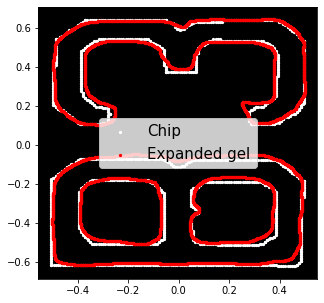

In [16]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.set_facecolor('k')
c,c_label,colors=[contours_chip,contours_gel],['Chip','Expanded gel'],['w','r']
for c_idx,contour in enumerate(c):
    color=np.random.rand(3)
    for idx,p in enumerate(contour):
        if idx==0:
            ax.scatter(*p.T,color=colors[c_idx],s=5,label=c_label[c_idx])
        else:
            ax.scatter(*p.T,color=colors[c_idx],s=5)
ax.legend(fontsize=15)

### We now build the triangulated mesh of the undeformed gel. The idea is to match the contours of the undeformed shapes to the contour of the deformed shapes with LDDMM (deformetrica), which will parameterize a deformation field (like wind blowing on the datapoints for smooth deformations). We can then take the triangulated mesh and deform each point according to the found deformation field, to see how the triangles change shape and size when undergoing the same deformation as the shape. We can then compare the same triangle in its undeformed and deformed state, and conclude about how isomorph the deformation is, how much the did the shape swell in general, and how regularly.

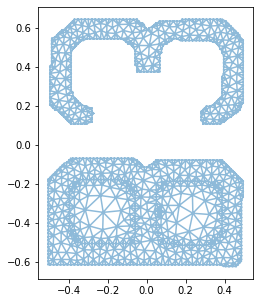

In [17]:
data.construct_chip_mesh(triangle_size=0.5)
data.plot_mesh(alpha=0.5)

#for deformation maps we use a finer mesh
data.construct_chip_mesh(triangle_size=0.01)


### We also want to know how much the gel or the void in the gel deform from the chip to the expanded state. To that end, we use the 'contour' function which delinates the boundaries of our letters and numbers, and our 'order_contour' function will allow us to tell which contour is a 'void', and which one is filled gel. We can then check for example if the holes in 'B' deform differently than the letter itself (structural instability)

In [18]:
data.make_vtk_files(decimate=2) #puts the triangle data into a vtk file for deformetrica to apply the LDMM algorithm
data.order_contours() # we find the contours of our shape, and match them in pair after the deformation
#so that we can then compute the expansion of voids, or expansion of filled parts ( e.g the holes in 'B' are filled )
data.create_shell_void_pairing() #which contour corresponds in chip B3 corresponds to which contour in gel B3
#order contours before restoring scale !

In [26]:
### We now run the deformation algorithm. deformetrica should be in your system path.

In [19]:
data.run_LDDMM()

INFO:deformetrica:No output directory defined, using default: /home/csaba/deformetrica/melissa_landmark/output
Logger has been set to: INFO
>> No initial CP spacing given: using diffeo kernel width of 15.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 4
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/csaba/deformetrica/melissa_landmark/output/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 238 control points defined.
>> Momenta initialized to zero, for 1 subjects.
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------
>> Log-likelihood = -4.153E+05 	 [ attachment = -4.153E+05 ; regulari

>> Log-likelihood = -2.730E+03 	 [ attachment = -1.450E+03 ; regularity = -1.280E+03 ]

------------------------------------- Iteration: 41 -------------------------------------
>> Log-likelihood = -2.716E+03 	 [ attachment = -1.435E+03 ; regularity = -1.282E+03 ]

------------------------------------- Iteration: 42 -------------------------------------
>> Log-likelihood = -2.694E+03 	 [ attachment = -1.407E+03 ; regularity = -1.287E+03 ]

------------------------------------- Iteration: 43 -------------------------------------
>> Log-likelihood = -2.678E+03 	 [ attachment = -1.384E+03 ; regularity = -1.294E+03 ]

------------------------------------- Iteration: 44 -------------------------------------
>> Log-likelihood = -2.667E+03 	 [ attachment = -1.368E+03 ; regularity = -1.298E+03 ]

------------------------------------- Iteration: 45 -------------------------------------
>> Log-likelihood = -2.642E+03 	 [ attachment = -1.324E+03 ; regularity = -1.318E+03 ]

----------------------

>> Log-likelihood = -2.314E+03 	 [ attachment = -9.012E+02 ; regularity = -1.413E+03 ]

------------------------------------- Iteration: 87 -------------------------------------
>> Log-likelihood = -2.314E+03 	 [ attachment = -9.004E+02 ; regularity = -1.413E+03 ]

------------------------------------- Iteration: 88 -------------------------------------
>> Log-likelihood = -2.310E+03 	 [ attachment = -8.973E+02 ; regularity = -1.413E+03 ]

------------------------------------- Iteration: 89 -------------------------------------
>> Log-likelihood = -2.308E+03 	 [ attachment = -8.961E+02 ; regularity = -1.412E+03 ]

------------------------------------- Iteration: 90 -------------------------------------
>> Log-likelihood = -2.305E+03 	 [ attachment = -8.934E+02 ; regularity = -1.412E+03 ]

------------------------------------- Iteration: 91 -------------------------------------
>> Log-likelihood = -2.304E+03 	 [ attachment = -8.922E+02 ; regularity = -1.412E+03 ]

----------------------

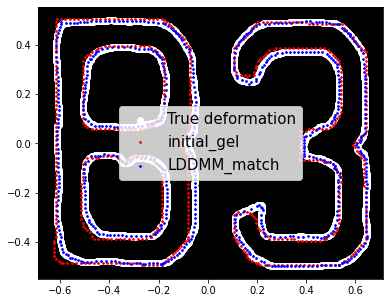

In [20]:
data.inspect_LDDMM_result()

In [21]:
data.deform_mesh_to_gel() #applies the deformation field found at the previous step to our triangularized mesh

Logger has been set to: WARNING
Defaulting geodesic t0 to 1.
Defaulting geodesic tmax to 1.
Defaulting geodesic tmin to 0.


In [22]:

data.get_gel_mesh_from_vtk() #convert back the deformed mesh from its vtk format to numpy mesh-triangle format
data.restore_scale() #undo the scaling we initially did to match the chip and gel contours in size


In [23]:
data.compute_triangle_areas()

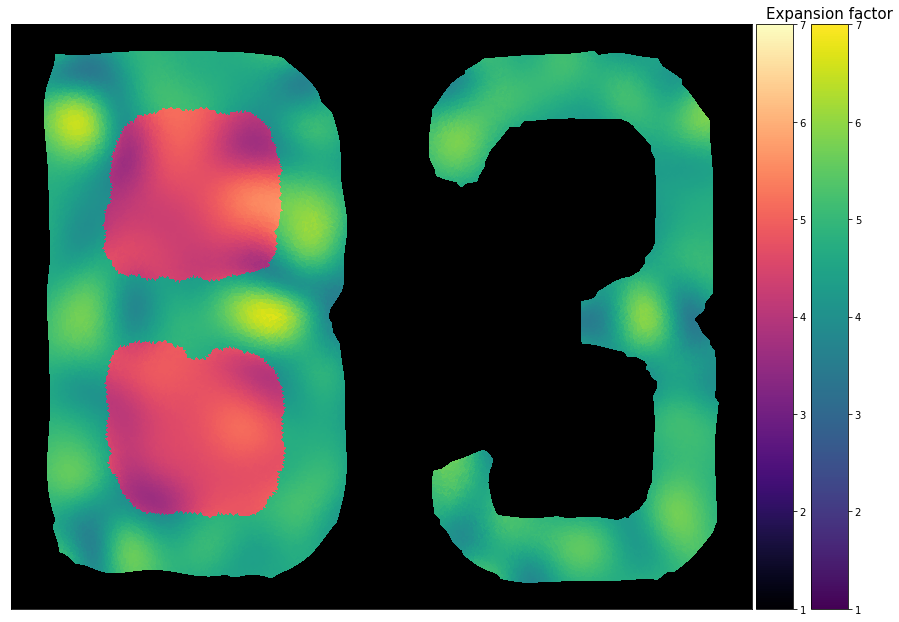

In [24]:
data.triplot_by_area(which='gel')

In [25]:
data.measure_random_segments(which='letter')

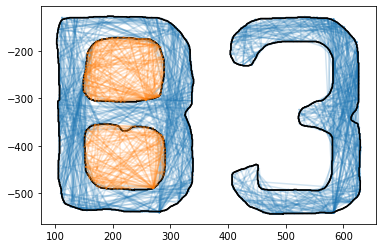

In [26]:
data.measure_random_segments(which='letter')
for c in data.contour_gel:
    plt.plot(c[:,1],-c[:,0],color='k')
for p in data.mesh_pairs:
    x=data.gel_mesh[p][:,1]
    y=data.gel_mesh[p][:,0]
    plt.plot(x,-y,color='#1f77b4',alpha=0.2)
data.measure_random_segments(which='void')
for c in data.contour_gel:
    plt.plot(c[:,1],-c[:,0],color='k')
for p in data.mesh_pairs:
    if np.random.rand()<0.1:
        x=data.gel_mesh[p][:,1]
        y=data.gel_mesh[p][:,0]
        plt.plot(x,-y,color='#ff7f0e',alpha=0.2)

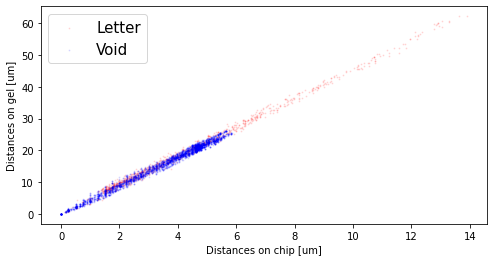

In [27]:
color=['r','b']
fig,ax=plt.subplots(1,1,figsize=(8,4))
for idx,which in enumerate(['letter','void']):
    data.measure_random_segments(which=which)
    ax.scatter(data.dists_chip,data.dists_gel,color=color[idx],s=1,alpha=0.1)
plt.xlabel('Distances on chip [um]')
plt.ylabel('Distances on gel [um]')
plt.legend(['Letter','Void'],fontsize=15)

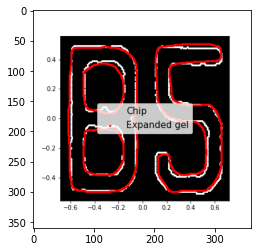

In [28]:

if not os.path.exists('Aligned_contours/'):
    os.mkdir('Aligned_contours')
if len(os.listdir('Aligned_contours/'))==0: #Only generate plots if folder is empty (otherwise, it's already been generated)
    for z in range(len(gels)):

        data=Data(gels,chips)
        contours_gel,contours_chip=data.create_aligned_contours(idx=z)

        fig,ax=plt.subplots(1,1,figsize=(5,5))
        ax.set_facecolor('k')
        c,c_label,colors=[contours_chip,contours_gel],['Chip','Expanded gel'],['w','r']
        for c_idx,contour in enumerate(c):
            color=np.random.rand(3)
            for idx,p in enumerate(contour):
                if idx==0:
                    p=p[:,::-1]*np.array([1,-1])
                    ax.scatter(*p.T,color=colors[c_idx],s=5,label=c_label[c_idx])
                else:
                    p=p[:,::-1]*np.array([1,-1])
                    ax.scatter(*p.T,color=colors[c_idx],s=5)
        ax.legend(fontsize=15,loc=0)
        plt.savefig('Aligned_contours/'+str(z)+'.png')
        if idx<len(gels)-1: #show the last inside this notebook
            plt.close()

plt.imshow(imread('Aligned_contours/15.png'))

### Run the entire pipeline on the full set of data

In [29]:
for img_idx in range(len(chips)):
    data=Data(gels,chips)
    contours_gel,contours_chip=data.create_aligned_contours(idx=img_idx)

    data.construct_chip_mesh(triangle_size=0.01)
    data.make_vtk_files(decimate=2)
    data.order_contours()
    data.create_shell_void_pairing()
    data.run_LDDMM()
    
    data.inspect_LDDMM_result()
    plt.savefig('plots/lddmm_results/'+data.pattern+'.png')
    plt.close()
    
    data.deform_mesh_to_gel()
    data.get_gel_mesh_from_vtk()
    data.restore_scale()

    data.compute_triangle_areas()
    data.triplot_by_area(which='gel')
    plt.savefig('plots/triangles/'+data.pattern+'_gel.png')
    plt.close()
    data.triplot_by_area(which='chip')
    plt.savefig('plots/triangles/'+data.pattern+'_chip.png')
    plt.close()
    
    for c in data.contour_gel:
        plt.plot(c[:,1],-c[:,0],color='b')
    color=['r','g']
    for idx,which in enumerate(['letter','void']):
        data.measure_random_segments(which=which)
        if len(data.mesh_pairs)>0:
            for p in data.mesh_pairs[np.random.randint(0,len(data.mesh_pairs),300)]:
                plt.plot(data.gel_mesh[p][:,1],-data.gel_mesh[p][:,0],color=color[idx],alpha=0.3)
    plt.savefig('plots/rays/'+data.pattern+'.png')
    plt.close()

INFO:deformetrica:No output directory defined, using default: /home/csaba/deformetrica/melissa_landmark/output
Logger has been set to: INFO
>> No initial CP spacing given: using diffeo kernel width of 15.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 4
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/csaba/deformetrica/melissa_landmark/output/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 364 control points defined.
>> Momenta initialized to zero, for 1 subjects.
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------
>> Log-likelihood = -2.971E+06 	 [ attachment = -2.971E+06 ; regulari

>> Log-likelihood = -1.106E+04 	 [ attachment = -2.152E+03 ; regularity = -8.910E+03 ]

------------------------------------- Iteration: 41 -------------------------------------
>> Log-likelihood = -1.102E+04 	 [ attachment = -2.115E+03 ; regularity = -8.901E+03 ]

------------------------------------- Iteration: 42 -------------------------------------
>> Log-likelihood = -1.095E+04 	 [ attachment = -2.052E+03 ; regularity = -8.897E+03 ]

------------------------------------- Iteration: 43 -------------------------------------
>> Log-likelihood = -1.091E+04 	 [ attachment = -2.018E+03 ; regularity = -8.896E+03 ]

------------------------------------- Iteration: 44 -------------------------------------
>> Log-likelihood = -1.087E+04 	 [ attachment = -1.980E+03 ; regularity = -8.892E+03 ]

------------------------------------- Iteration: 45 -------------------------------------
>> Log-likelihood = -1.083E+04 	 [ attachment = -1.947E+03 ; regularity = -8.884E+03 ]

----------------------

>> Log-likelihood = -9.659E+03 	 [ attachment = -1.161E+03 ; regularity = -8.498E+03 ]

------------------------------------- Iteration: 87 -------------------------------------
>> Log-likelihood = -9.643E+03 	 [ attachment = -1.150E+03 ; regularity = -8.493E+03 ]

------------------------------------- Iteration: 88 -------------------------------------
>> Log-likelihood = -9.628E+03 	 [ attachment = -1.142E+03 ; regularity = -8.486E+03 ]

------------------------------------- Iteration: 89 -------------------------------------
>> Log-likelihood = -9.617E+03 	 [ attachment = -1.130E+03 ; regularity = -8.486E+03 ]

------------------------------------- Iteration: 90 -------------------------------------
>> Log-likelihood = -9.600E+03 	 [ attachment = -1.118E+03 ; regularity = -8.482E+03 ]

------------------------------------- Iteration: 91 -------------------------------------
>> Log-likelihood = -9.591E+03 	 [ attachment = -1.110E+03 ; regularity = -8.481E+03 ]

----------------------

>> Log-likelihood = -3.720E+03 	 [ attachment = -2.115E+03 ; regularity = -1.605E+03 ]

------------------------------------- Iteration: 22 -------------------------------------
>> Log-likelihood = -3.573E+03 	 [ attachment = -1.948E+03 ; regularity = -1.625E+03 ]

------------------------------------- Iteration: 23 -------------------------------------
>> Log-likelihood = -3.430E+03 	 [ attachment = -1.780E+03 ; regularity = -1.650E+03 ]

------------------------------------- Iteration: 24 -------------------------------------
>> Log-likelihood = -3.343E+03 	 [ attachment = -1.691E+03 ; regularity = -1.652E+03 ]

------------------------------------- Iteration: 25 -------------------------------------
>> Log-likelihood = -3.234E+03 	 [ attachment = -1.572E+03 ; regularity = -1.662E+03 ]

------------------------------------- Iteration: 26 -------------------------------------
>> Log-likelihood = -3.147E+03 	 [ attachment = -1.465E+03 ; regularity = -1.682E+03 ]

----------------------

>> Log-likelihood = -2.507E+03 	 [ attachment = -6.730E+02 ; regularity = -1.834E+03 ]

------------------------------------- Iteration: 68 -------------------------------------
>> Log-likelihood = -2.502E+03 	 [ attachment = -6.680E+02 ; regularity = -1.834E+03 ]

------------------------------------- Iteration: 69 -------------------------------------
>> Log-likelihood = -2.499E+03 	 [ attachment = -6.652E+02 ; regularity = -1.834E+03 ]

------------------------------------- Iteration: 70 -------------------------------------
>> Log-likelihood = -2.494E+03 	 [ attachment = -6.605E+02 ; regularity = -1.833E+03 ]

------------------------------------- Iteration: 71 -------------------------------------
>> Log-likelihood = -2.490E+03 	 [ attachment = -6.578E+02 ; regularity = -1.832E+03 ]

------------------------------------- Iteration: 72 -------------------------------------
>> Log-likelihood = -2.485E+03 	 [ attachment = -6.523E+02 ; regularity = -1.833E+03 ]

----------------------

INFO:deformetrica:No output directory defined, using default: /home/csaba/deformetrica/melissa_landmark/output
Logger has been set to: INFO
>> No initial CP spacing given: using diffeo kernel width of 15.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 4
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/csaba/deformetrica/melissa_landmark/output/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 238 control points defined.
>> Momenta initialized to zero, for 1 subjects.
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------
>> Log-likelihood = -6.025E+05 	 [ attachment = -6.025E+05 ; regulari

>> Log-likelihood = -2.543E+03 	 [ attachment = -1.120E+03 ; regularity = -1.423E+03 ]

------------------------------------- Iteration: 42 -------------------------------------
>> Log-likelihood = -2.524E+03 	 [ attachment = -1.103E+03 ; regularity = -1.421E+03 ]

------------------------------------- Iteration: 43 -------------------------------------
>> Log-likelihood = -2.513E+03 	 [ attachment = -1.093E+03 ; regularity = -1.420E+03 ]

------------------------------------- Iteration: 44 -------------------------------------
>> Log-likelihood = -2.498E+03 	 [ attachment = -1.078E+03 ; regularity = -1.420E+03 ]

------------------------------------- Iteration: 45 -------------------------------------
>> Log-likelihood = -2.483E+03 	 [ attachment = -1.056E+03 ; regularity = -1.427E+03 ]

------------------------------------- Iteration: 46 -------------------------------------
>> Log-likelihood = -2.460E+03 	 [ attachment = -1.031E+03 ; regularity = -1.429E+03 ]

----------------------

>> Log-likelihood = -2.204E+03 	 [ attachment = -6.914E+02 ; regularity = -1.512E+03 ]
>> Log-likelihood = -2.204E+03 	 [ attachment = -6.914E+02 ; regularity = -1.512E+03 ]
>> Log-likelihood = -2.203E+03 	 [ attachment = -6.906E+02 ; regularity = -1.512E+03 ]
>> Log-likelihood = -2.203E+03 	 [ attachment = -6.906E+02 ; regularity = -1.512E+03 ]
>> Log-likelihood = -2.203E+03 	 [ attachment = -6.906E+02 ; regularity = -1.512E+03 ]
>> Log-likelihood = -2.203E+03 	 [ attachment = -6.906E+02 ; regularity = -1.512E+03 ]
>> Log-likelihood = -2.203E+03 	 [ attachment = -6.906E+02 ; regularity = -1.512E+03 ]
>> Log-likelihood = -2.203E+03 	 [ attachment = -6.906E+02 ; regularity = -1.512E+03 ]
>> Log-likelihood = -1.643E+06 	 [ attachment = -1.635E+06 ; regularity = -7.461E+03 ]
>> Log-likelihood = -2.203E+03 	 [ attachment = -6.902E+02 ; regularity = -1.512E+03 ]

------------------------------------- Iteration: 87 -------------------------------------
>> CONVERGENCE: REL_REDUCTION_OF_F_<=_F

>> Log-likelihood = -3.134E+03 	 [ attachment = -1.413E+03 ; regularity = -1.721E+03 ]

------------------------------------- Iteration: 35 -------------------------------------
>> Log-likelihood = -3.088E+03 	 [ attachment = -1.355E+03 ; regularity = -1.733E+03 ]

------------------------------------- Iteration: 36 -------------------------------------
>> Log-likelihood = -3.071E+03 	 [ attachment = -1.311E+03 ; regularity = -1.760E+03 ]

------------------------------------- Iteration: 37 -------------------------------------
>> Log-likelihood = -3.029E+03 	 [ attachment = -1.279E+03 ; regularity = -1.750E+03 ]

------------------------------------- Iteration: 38 -------------------------------------
>> Log-likelihood = -3.016E+03 	 [ attachment = -1.270E+03 ; regularity = -1.746E+03 ]

------------------------------------- Iteration: 39 -------------------------------------
>> Log-likelihood = -2.994E+03 	 [ attachment = -1.252E+03 ; regularity = -1.742E+03 ]

----------------------

>> Log-likelihood = -2.581E+03 	 [ attachment = -7.348E+02 ; regularity = -1.847E+03 ]

------------------------------------- Iteration: 81 -------------------------------------
>> Log-likelihood = -2.577E+03 	 [ attachment = -7.305E+02 ; regularity = -1.847E+03 ]

------------------------------------- Iteration: 82 -------------------------------------
>> Log-likelihood = -2.572E+03 	 [ attachment = -7.266E+02 ; regularity = -1.846E+03 ]

------------------------------------- Iteration: 83 -------------------------------------
>> Log-likelihood = -2.569E+03 	 [ attachment = -7.250E+02 ; regularity = -1.844E+03 ]

------------------------------------- Iteration: 84 -------------------------------------
>> Log-likelihood = -2.562E+03 	 [ attachment = -7.188E+02 ; regularity = -1.843E+03 ]

------------------------------------- Iteration: 85 -------------------------------------
>> Log-likelihood = -2.560E+03 	 [ attachment = -7.176E+02 ; regularity = -1.842E+03 ]

----------------------

>> Log-likelihood = -3.005E+03 	 [ attachment = -1.472E+03 ; regularity = -1.533E+03 ]

------------------------------------- Iteration: 27 -------------------------------------
>> Log-likelihood = -2.956E+03 	 [ attachment = -1.396E+03 ; regularity = -1.560E+03 ]

------------------------------------- Iteration: 28 -------------------------------------
>> Log-likelihood = -2.912E+03 	 [ attachment = -1.328E+03 ; regularity = -1.584E+03 ]

------------------------------------- Iteration: 29 -------------------------------------
>> Log-likelihood = -2.872E+03 	 [ attachment = -1.278E+03 ; regularity = -1.594E+03 ]

------------------------------------- Iteration: 30 -------------------------------------
>> Log-likelihood = -2.826E+03 	 [ attachment = -1.221E+03 ; regularity = -1.605E+03 ]

------------------------------------- Iteration: 31 -------------------------------------
>> Log-likelihood = -2.801E+03 	 [ attachment = -1.189E+03 ; regularity = -1.612E+03 ]

----------------------

>> Log-likelihood = -2.245E+03 	 [ attachment = -5.023E+02 ; regularity = -1.743E+03 ]

------------------------------------- Iteration: 73 -------------------------------------
>> Log-likelihood = -2.241E+03 	 [ attachment = -4.996E+02 ; regularity = -1.741E+03 ]

------------------------------------- Iteration: 74 -------------------------------------
>> Log-likelihood = -2.238E+03 	 [ attachment = -4.992E+02 ; regularity = -1.738E+03 ]

------------------------------------- Iteration: 75 -------------------------------------
>> Log-likelihood = -2.238E+03 	 [ attachment = -5.027E+02 ; regularity = -1.735E+03 ]

------------------------------------- Iteration: 76 -------------------------------------
>> CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
>> Estimation took: 07 seconds
Logger has been set to: WARNING
Defaulting geodesic t0 to 1.
Defaulting geodesic tmax to 1.
Defaulting geodesic tmin to 0.
INFO:deformetrica:No output directory defined, using default: /home/csaba/deformetr

>> Log-likelihood = -3.634E+03 	 [ attachment = -1.706E+03 ; regularity = -1.928E+03 ]

------------------------------------- Iteration: 36 -------------------------------------
>> Log-likelihood = -3.595E+03 	 [ attachment = -1.655E+03 ; regularity = -1.940E+03 ]

------------------------------------- Iteration: 37 -------------------------------------
>> Log-likelihood = -3.556E+03 	 [ attachment = -1.602E+03 ; regularity = -1.953E+03 ]

------------------------------------- Iteration: 38 -------------------------------------
>> Log-likelihood = -3.515E+03 	 [ attachment = -1.548E+03 ; regularity = -1.967E+03 ]

------------------------------------- Iteration: 39 -------------------------------------
>> Log-likelihood = -3.480E+03 	 [ attachment = -1.511E+03 ; regularity = -1.969E+03 ]

------------------------------------- Iteration: 40 -------------------------------------
>> Log-likelihood = -3.440E+03 	 [ attachment = -1.466E+03 ; regularity = -1.975E+03 ]

----------------------

>> Log-likelihood = -2.997E+03 	 [ attachment = -8.355E+02 ; regularity = -2.161E+03 ]

------------------------------------- Iteration: 82 -------------------------------------
>> Log-likelihood = -2.993E+03 	 [ attachment = -8.320E+02 ; regularity = -2.161E+03 ]

------------------------------------- Iteration: 83 -------------------------------------
>> Log-likelihood = -2.989E+03 	 [ attachment = -8.289E+02 ; regularity = -2.160E+03 ]

------------------------------------- Iteration: 84 -------------------------------------
>> Log-likelihood = -2.982E+03 	 [ attachment = -8.238E+02 ; regularity = -2.158E+03 ]

------------------------------------- Iteration: 85 -------------------------------------
>> Log-likelihood = -2.978E+03 	 [ attachment = -8.227E+02 ; regularity = -2.156E+03 ]

------------------------------------- Iteration: 86 -------------------------------------
>> Log-likelihood = -2.974E+03 	 [ attachment = -8.195E+02 ; regularity = -2.155E+03 ]

----------------------

>> Log-likelihood = -7.579E+03 	 [ attachment = -5.894E+03 ; regularity = -1.686E+03 ]

------------------------------------- Iteration: 13 -------------------------------------
>> Log-likelihood = -6.773E+03 	 [ attachment = -5.004E+03 ; regularity = -1.769E+03 ]

------------------------------------- Iteration: 14 -------------------------------------
>> Log-likelihood = -6.285E+03 	 [ attachment = -4.489E+03 ; regularity = -1.796E+03 ]

------------------------------------- Iteration: 15 -------------------------------------
>> Log-likelihood = -5.926E+03 	 [ attachment = -4.102E+03 ; regularity = -1.824E+03 ]

------------------------------------- Iteration: 16 -------------------------------------
>> Log-likelihood = -5.531E+03 	 [ attachment = -3.678E+03 ; regularity = -1.853E+03 ]

------------------------------------- Iteration: 17 -------------------------------------
>> Log-likelihood = -5.134E+03 	 [ attachment = -3.237E+03 ; regularity = -1.897E+03 ]

----------------------

>> Log-likelihood = -2.918E+03 	 [ attachment = -8.184E+02 ; regularity = -2.100E+03 ]

------------------------------------- Iteration: 59 -------------------------------------
>> Log-likelihood = -2.908E+03 	 [ attachment = -8.098E+02 ; regularity = -2.098E+03 ]

------------------------------------- Iteration: 60 -------------------------------------
>> Log-likelihood = -2.894E+03 	 [ attachment = -8.000E+02 ; regularity = -2.094E+03 ]

------------------------------------- Iteration: 61 -------------------------------------
>> Log-likelihood = -2.884E+03 	 [ attachment = -7.918E+02 ; regularity = -2.092E+03 ]

------------------------------------- Iteration: 62 -------------------------------------
>> Log-likelihood = -2.876E+03 	 [ attachment = -7.844E+02 ; regularity = -2.092E+03 ]

------------------------------------- Iteration: 63 -------------------------------------
>> Log-likelihood = -2.872E+03 	 [ attachment = -7.812E+02 ; regularity = -2.091E+03 ]

----------------------

>> Log-likelihood = -2.710E+03 	 [ attachment = -6.523E+02 ; regularity = -2.058E+03 ]
>> Log-likelihood = -2.710E+03 	 [ attachment = -6.516E+02 ; regularity = -2.058E+03 ]
>> Log-likelihood = -2.709E+03 	 [ attachment = -6.508E+02 ; regularity = -2.058E+03 ]
>> Log-likelihood = -2.709E+03 	 [ attachment = -6.508E+02 ; regularity = -2.058E+03 ]
>> Number of line search loops exceeded. Stopping.
>> Estimation took: 10 seconds
Logger has been set to: WARNING
Defaulting geodesic t0 to 1.
Defaulting geodesic tmax to 1.
Defaulting geodesic tmin to 0.
INFO:deformetrica:No output directory defined, using default: /home/csaba/deformetrica/melissa_landmark/output
Logger has been set to: INFO
>> No initial CP spacing given: using diffeo kernel width of 15.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 4
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/csaba/deformetrica/melissa_landm

>> Log-likelihood = -1.964E+03 	 [ attachment = -8.160E+02 ; regularity = -1.148E+03 ]

------------------------------------- Iteration: 39 -------------------------------------
>> Log-likelihood = -1.953E+03 	 [ attachment = -7.977E+02 ; regularity = -1.155E+03 ]

------------------------------------- Iteration: 40 -------------------------------------
>> Log-likelihood = -1.934E+03 	 [ attachment = -7.688E+02 ; regularity = -1.165E+03 ]

------------------------------------- Iteration: 41 -------------------------------------
>> Log-likelihood = -1.918E+03 	 [ attachment = -7.484E+02 ; regularity = -1.170E+03 ]

------------------------------------- Iteration: 42 -------------------------------------
>> Log-likelihood = -1.904E+03 	 [ attachment = -7.355E+02 ; regularity = -1.169E+03 ]

------------------------------------- Iteration: 43 -------------------------------------
>> Log-likelihood = -1.895E+03 	 [ attachment = -7.242E+02 ; regularity = -1.170E+03 ]

----------------------

>> Estimation took: 07 seconds
Logger has been set to: WARNING
Defaulting geodesic t0 to 1.
Defaulting geodesic tmax to 1.
Defaulting geodesic tmin to 0.
INFO:deformetrica:No output directory defined, using default: /home/csaba/deformetrica/melissa_landmark/output
Logger has been set to: INFO
>> No initial CP spacing given: using diffeo kernel width of 15.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 4
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/csaba/deformetrica/melissa_landmark/output/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 238 control points defined.
>> Momenta initialized to zero, for 1 subjects.
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

----

>> Log-likelihood = -3.912E+03 	 [ attachment = -1.332E+03 ; regularity = -2.580E+03 ]

------------------------------------- Iteration: 41 -------------------------------------
>> Log-likelihood = -3.884E+03 	 [ attachment = -1.295E+03 ; regularity = -2.589E+03 ]

------------------------------------- Iteration: 42 -------------------------------------
>> Log-likelihood = -3.867E+03 	 [ attachment = -1.270E+03 ; regularity = -2.597E+03 ]

------------------------------------- Iteration: 43 -------------------------------------
>> Log-likelihood = -3.843E+03 	 [ attachment = -1.242E+03 ; regularity = -2.601E+03 ]

------------------------------------- Iteration: 44 -------------------------------------
>> Log-likelihood = -3.822E+03 	 [ attachment = -1.216E+03 ; regularity = -2.606E+03 ]

------------------------------------- Iteration: 45 -------------------------------------
>> Log-likelihood = -3.804E+03 	 [ attachment = -1.196E+03 ; regularity = -2.608E+03 ]

----------------------

>> Log-likelihood = -3.426E+03 	 [ attachment = -7.617E+02 ; regularity = -2.665E+03 ]

------------------------------------- Iteration: 87 -------------------------------------
>> Log-likelihood = -3.422E+03 	 [ attachment = -7.551E+02 ; regularity = -2.667E+03 ]

------------------------------------- Iteration: 88 -------------------------------------
>> Log-likelihood = -3.427E+03 	 [ attachment = -7.570E+02 ; regularity = -2.670E+03 ]
>> Log-likelihood = -3.418E+03 	 [ attachment = -7.508E+02 ; regularity = -2.668E+03 ]

------------------------------------- Iteration: 89 -------------------------------------
>> Log-likelihood = -3.417E+03 	 [ attachment = -7.465E+02 ; regularity = -2.670E+03 ]

------------------------------------- Iteration: 90 -------------------------------------
>> Log-likelihood = -3.414E+03 	 [ attachment = -7.422E+02 ; regularity = -2.671E+03 ]

------------------------------------- Iteration: 91 -------------------------------------
>> Log-likelihood = -3.

>> Log-likelihood = -4.259E+03 	 [ attachment = -1.628E+03 ; regularity = -2.631E+03 ]

------------------------------------- Iteration: 29 -------------------------------------
>> Log-likelihood = -4.193E+03 	 [ attachment = -1.557E+03 ; regularity = -2.636E+03 ]

------------------------------------- Iteration: 30 -------------------------------------
>> Log-likelihood = -4.145E+03 	 [ attachment = -1.503E+03 ; regularity = -2.641E+03 ]

------------------------------------- Iteration: 31 -------------------------------------
>> Log-likelihood = -4.092E+03 	 [ attachment = -1.441E+03 ; regularity = -2.650E+03 ]

------------------------------------- Iteration: 32 -------------------------------------
>> Log-likelihood = -4.009E+03 	 [ attachment = -1.346E+03 ; regularity = -2.663E+03 ]

------------------------------------- Iteration: 33 -------------------------------------
>> Log-likelihood = -3.970E+03 	 [ attachment = -1.273E+03 ; regularity = -2.698E+03 ]

----------------------

>> Log-likelihood = -3.369E+03 	 [ attachment = -5.961E+02 ; regularity = -2.773E+03 ]

------------------------------------- Iteration: 75 -------------------------------------
>> Log-likelihood = -3.366E+03 	 [ attachment = -5.906E+02 ; regularity = -2.775E+03 ]

------------------------------------- Iteration: 76 -------------------------------------
>> Log-likelihood = -3.362E+03 	 [ attachment = -5.855E+02 ; regularity = -2.776E+03 ]

------------------------------------- Iteration: 77 -------------------------------------
>> Log-likelihood = -3.358E+03 	 [ attachment = -5.812E+02 ; regularity = -2.777E+03 ]

------------------------------------- Iteration: 78 -------------------------------------
>> Log-likelihood = -3.358E+03 	 [ attachment = -5.805E+02 ; regularity = -2.777E+03 ]

------------------------------------- Iteration: 79 -------------------------------------
>> Log-likelihood = -3.356E+03 	 [ attachment = -5.766E+02 ; regularity = -2.779E+03 ]

----------------------

>> Log-likelihood = -1.116E+04 	 [ attachment = -4.330E+03 ; regularity = -6.832E+03 ]

------------------------------------- Iteration: 23 -------------------------------------
>> Log-likelihood = -1.094E+04 	 [ attachment = -4.072E+03 ; regularity = -6.871E+03 ]

------------------------------------- Iteration: 24 -------------------------------------
>> Log-likelihood = -1.077E+04 	 [ attachment = -3.869E+03 ; regularity = -6.900E+03 ]

------------------------------------- Iteration: 25 -------------------------------------
>> Log-likelihood = -1.063E+04 	 [ attachment = -3.720E+03 ; regularity = -6.910E+03 ]

------------------------------------- Iteration: 26 -------------------------------------
>> Log-likelihood = -1.046E+04 	 [ attachment = -3.538E+03 ; regularity = -6.925E+03 ]

------------------------------------- Iteration: 27 -------------------------------------
>> Log-likelihood = -1.033E+04 	 [ attachment = -3.396E+03 ; regularity = -6.935E+03 ]

----------------------

>> Log-likelihood = -8.484E+03 	 [ attachment = -1.283E+03 ; regularity = -7.201E+03 ]

------------------------------------- Iteration: 70 -------------------------------------
>> Log-likelihood = -8.463E+03 	 [ attachment = -1.259E+03 ; regularity = -7.204E+03 ]

------------------------------------- Iteration: 71 -------------------------------------
>> Log-likelihood = -8.447E+03 	 [ attachment = -1.251E+03 ; regularity = -7.196E+03 ]

------------------------------------- Iteration: 72 -------------------------------------
>> Log-likelihood = -8.435E+03 	 [ attachment = -1.240E+03 ; regularity = -7.195E+03 ]

------------------------------------- Iteration: 73 -------------------------------------
>> Log-likelihood = -8.424E+03 	 [ attachment = -1.234E+03 ; regularity = -7.191E+03 ]

------------------------------------- Iteration: 74 -------------------------------------
>> Log-likelihood = -8.416E+03 	 [ attachment = -1.230E+03 ; regularity = -7.187E+03 ]

----------------------

>> Log-likelihood = -8.199E+03 	 [ attachment = -1.117E+03 ; regularity = -7.082E+03 ]
>> Log-likelihood = -8.194E+03 	 [ attachment = -1.112E+03 ; regularity = -7.082E+03 ]
>> Log-likelihood = -8.194E+03 	 [ attachment = -1.112E+03 ; regularity = -7.082E+03 ]
>> Log-likelihood = -8.194E+03 	 [ attachment = -1.112E+03 ; regularity = -7.082E+03 ]
>> Log-likelihood = -8.194E+03 	 [ attachment = -1.112E+03 ; regularity = -7.082E+03 ]
>> Log-likelihood = -8.194E+03 	 [ attachment = -1.112E+03 ; regularity = -7.082E+03 ]
>> Log-likelihood = -8.194E+03 	 [ attachment = -1.112E+03 ; regularity = -7.082E+03 ]
>> Number of line search loops exceeded. Stopping.
>> Estimation took: 19 seconds
Logger has been set to: WARNING
Defaulting geodesic t0 to 1.
Defaulting geodesic tmax to 1.
Defaulting geodesic tmin to 0.
INFO:deformetrica:No output directory defined, using default: /home/csaba/deformetrica/melissa_landmark/output
Logger has been set to: INFO
>> No initial CP spacing given: using diffeo k

>> Log-likelihood = -3.105E+03 	 [ attachment = -1.191E+03 ; regularity = -1.915E+03 ]

------------------------------------- Iteration: 37 -------------------------------------
>> Log-likelihood = -3.084E+03 	 [ attachment = -1.167E+03 ; regularity = -1.917E+03 ]

------------------------------------- Iteration: 38 -------------------------------------
>> Log-likelihood = -3.063E+03 	 [ attachment = -1.140E+03 ; regularity = -1.923E+03 ]

------------------------------------- Iteration: 39 -------------------------------------
>> Log-likelihood = -3.044E+03 	 [ attachment = -1.104E+03 ; regularity = -1.940E+03 ]

------------------------------------- Iteration: 40 -------------------------------------
>> Log-likelihood = -3.017E+03 	 [ attachment = -1.071E+03 ; regularity = -1.946E+03 ]

------------------------------------- Iteration: 41 -------------------------------------
>> Log-likelihood = -3.002E+03 	 [ attachment = -1.050E+03 ; regularity = -1.952E+03 ]

----------------------

>> Log-likelihood = -2.687E+03 	 [ attachment = -6.887E+02 ; regularity = -1.998E+03 ]

------------------------------------- Iteration: 84 -------------------------------------
>> Log-likelihood = -2.684E+03 	 [ attachment = -6.859E+02 ; regularity = -1.999E+03 ]

------------------------------------- Iteration: 85 -------------------------------------
>> Log-likelihood = -2.682E+03 	 [ attachment = -6.820E+02 ; regularity = -2.000E+03 ]

------------------------------------- Iteration: 86 -------------------------------------
>> Log-likelihood = -2.677E+03 	 [ attachment = -6.777E+02 ; regularity = -2.000E+03 ]

------------------------------------- Iteration: 87 -------------------------------------
>> Log-likelihood = -2.676E+03 	 [ attachment = -6.770E+02 ; regularity = -1.999E+03 ]

------------------------------------- Iteration: 88 -------------------------------------
>> Log-likelihood = -2.673E+03 	 [ attachment = -6.742E+02 ; regularity = -1.999E+03 ]

----------------------

>> Log-likelihood = -5.172E+05 	 [ attachment = -5.127E+05 ; regularity = -4.466E+03 ]

------------------------------------- Iteration: 3 -------------------------------------
>> Log-likelihood = -9.798E+04 	 [ attachment = -9.602E+04 ; regularity = -1.964E+03 ]

------------------------------------- Iteration: 4 -------------------------------------
>> Log-likelihood = -5.028E+04 	 [ attachment = -4.868E+04 ; regularity = -1.601E+03 ]

------------------------------------- Iteration: 5 -------------------------------------
>> Log-likelihood = -2.574E+04 	 [ attachment = -2.381E+04 ; regularity = -1.928E+03 ]

------------------------------------- Iteration: 6 -------------------------------------
>> Log-likelihood = -1.869E+04 	 [ attachment = -1.660E+04 ; regularity = -2.094E+03 ]

------------------------------------- Iteration: 7 -------------------------------------
>> Log-likelihood = -1.620E+04 	 [ attachment = -1.406E+04 ; regularity = -2.139E+03 ]

---------------------------

>> Log-likelihood = -4.353E+03 	 [ attachment = -1.455E+03 ; regularity = -2.898E+03 ]

------------------------------------- Iteration: 49 -------------------------------------
>> Log-likelihood = -4.321E+03 	 [ attachment = -1.419E+03 ; regularity = -2.902E+03 ]

------------------------------------- Iteration: 50 -------------------------------------
>> Log-likelihood = -4.311E+03 	 [ attachment = -1.409E+03 ; regularity = -2.902E+03 ]

------------------------------------- Iteration: 51 -------------------------------------
>> Log-likelihood = -4.302E+03 	 [ attachment = -1.395E+03 ; regularity = -2.907E+03 ]

------------------------------------- Iteration: 52 -------------------------------------
>> Log-likelihood = -4.293E+03 	 [ attachment = -1.375E+03 ; regularity = -2.918E+03 ]

------------------------------------- Iteration: 53 -------------------------------------
>> Log-likelihood = -4.278E+03 	 [ attachment = -1.360E+03 ; regularity = -2.918E+03 ]

----------------------

>> Log-likelihood = -3.932E+03 	 [ attachment = -9.711E+02 ; regularity = -2.961E+03 ]

------------------------------------- Iteration: 95 -------------------------------------
>> Log-likelihood = -3.931E+03 	 [ attachment = -9.699E+02 ; regularity = -2.961E+03 ]

------------------------------------- Iteration: 96 -------------------------------------
>> Log-likelihood = -3.929E+03 	 [ attachment = -9.680E+02 ; regularity = -2.961E+03 ]

------------------------------------- Iteration: 97 -------------------------------------
>> Log-likelihood = -3.927E+03 	 [ attachment = -9.656E+02 ; regularity = -2.961E+03 ]

------------------------------------- Iteration: 98 -------------------------------------
>> Log-likelihood = -3.924E+03 	 [ attachment = -9.633E+02 ; regularity = -2.961E+03 ]

------------------------------------- Iteration: 99 -------------------------------------
>> Log-likelihood = -3.921E+03 	 [ attachment = -9.602E+02 ; regularity = -2.961E+03 ]

----------------------

>> Log-likelihood = -6.973E+03 	 [ attachment = -5.968E+03 ; regularity = -1.005E+03 ]
>> Log-likelihood = -6.292E+03 	 [ attachment = -5.360E+03 ; regularity = -9.321E+02 ]

------------------------------------- Iteration: 13 -------------------------------------
>> Log-likelihood = -5.820E+03 	 [ attachment = -4.855E+03 ; regularity = -9.647E+02 ]

------------------------------------- Iteration: 14 -------------------------------------
>> Log-likelihood = -5.510E+03 	 [ attachment = -4.529E+03 ; regularity = -9.806E+02 ]

------------------------------------- Iteration: 15 -------------------------------------
>> Log-likelihood = -5.159E+03 	 [ attachment = -4.157E+03 ; regularity = -1.001E+03 ]

------------------------------------- Iteration: 16 -------------------------------------
>> Log-likelihood = -4.830E+03 	 [ attachment = -3.808E+03 ; regularity = -1.022E+03 ]

------------------------------------- Iteration: 17 -------------------------------------
>> Log-likelihood = -4.

>> Log-likelihood = -2.461E+03 	 [ attachment = -1.061E+03 ; regularity = -1.401E+03 ]

------------------------------------- Iteration: 59 -------------------------------------
>> Log-likelihood = -2.452E+03 	 [ attachment = -1.046E+03 ; regularity = -1.406E+03 ]

------------------------------------- Iteration: 60 -------------------------------------
>> Log-likelihood = -2.443E+03 	 [ attachment = -1.025E+03 ; regularity = -1.418E+03 ]

------------------------------------- Iteration: 61 -------------------------------------
>> Log-likelihood = -2.436E+03 	 [ attachment = -1.015E+03 ; regularity = -1.421E+03 ]

------------------------------------- Iteration: 62 -------------------------------------
>> Log-likelihood = -2.429E+03 	 [ attachment = -1.002E+03 ; regularity = -1.427E+03 ]

------------------------------------- Iteration: 63 -------------------------------------
>> Log-likelihood = -2.422E+03 	 [ attachment = -9.895E+02 ; regularity = -1.432E+03 ]

----------------------

Defaulting geodesic t0 to 1.
Defaulting geodesic tmax to 1.
Defaulting geodesic tmin to 0.
INFO:deformetrica:No output directory defined, using default: /home/csaba/deformetrica/melissa_landmark/output
Logger has been set to: INFO
>> No initial CP spacing given: using diffeo kernel width of 15.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 4
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/csaba/deformetrica/melissa_landmark/output/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 252 control points defined.
>> Momenta initialized to zero, for 1 subjects.
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 ----------------

>> Log-likelihood = -1.888E+03 	 [ attachment = -1.200E+03 ; regularity = -6.879E+02 ]

------------------------------------- Iteration: 41 -------------------------------------
>> Log-likelihood = -1.867E+03 	 [ attachment = -1.167E+03 ; regularity = -7.000E+02 ]

------------------------------------- Iteration: 42 -------------------------------------
>> Log-likelihood = -1.856E+03 	 [ attachment = -1.152E+03 ; regularity = -7.049E+02 ]

------------------------------------- Iteration: 43 -------------------------------------
>> Log-likelihood = -1.844E+03 	 [ attachment = -1.137E+03 ; regularity = -7.068E+02 ]

------------------------------------- Iteration: 44 -------------------------------------
>> Log-likelihood = -1.828E+03 	 [ attachment = -1.117E+03 ; regularity = -7.113E+02 ]

------------------------------------- Iteration: 45 -------------------------------------
>> Log-likelihood = -1.820E+03 	 [ attachment = -1.106E+03 ; regularity = -7.143E+02 ]

----------------------

>> Log-likelihood = -1.618E+03 	 [ attachment = -8.227E+02 ; regularity = -7.950E+02 ]

------------------------------------- Iteration: 87 -------------------------------------
>> Log-likelihood = -1.616E+03 	 [ attachment = -8.211E+02 ; regularity = -7.949E+02 ]

------------------------------------- Iteration: 88 -------------------------------------
>> Log-likelihood = -1.613E+03 	 [ attachment = -8.188E+02 ; regularity = -7.946E+02 ]

------------------------------------- Iteration: 89 -------------------------------------
>> Log-likelihood = -1.617E+03 	 [ attachment = -8.238E+02 ; regularity = -7.932E+02 ]
>> Log-likelihood = -1.613E+03 	 [ attachment = -8.188E+02 ; regularity = -7.939E+02 ]

------------------------------------- Iteration: 90 -------------------------------------
>> Log-likelihood = -1.607E+03 	 [ attachment = -8.133E+02 ; regularity = -7.940E+02 ]

------------------------------------- Iteration: 91 -------------------------------------
>> Log-likelihood = -1.

>> Log-likelihood = -3.311E+03 	 [ attachment = -2.004E+03 ; regularity = -1.307E+03 ]

------------------------------------- Iteration: 24 -------------------------------------
>> Log-likelihood = -3.207E+03 	 [ attachment = -1.904E+03 ; regularity = -1.303E+03 ]

------------------------------------- Iteration: 25 -------------------------------------
>> Log-likelihood = -3.147E+03 	 [ attachment = -1.845E+03 ; regularity = -1.302E+03 ]

------------------------------------- Iteration: 26 -------------------------------------
>> Log-likelihood = -3.081E+03 	 [ attachment = -1.775E+03 ; regularity = -1.306E+03 ]

------------------------------------- Iteration: 27 -------------------------------------
>> Log-likelihood = -3.016E+03 	 [ attachment = -1.703E+03 ; regularity = -1.313E+03 ]

------------------------------------- Iteration: 28 -------------------------------------
>> Log-likelihood = -2.962E+03 	 [ attachment = -1.632E+03 ; regularity = -1.329E+03 ]

----------------------

>> Log-likelihood = -2.215E+03 	 [ attachment = -7.371E+02 ; regularity = -1.478E+03 ]

------------------------------------- Iteration: 70 -------------------------------------
>> Log-likelihood = -2.210E+03 	 [ attachment = -7.309E+02 ; regularity = -1.480E+03 ]

------------------------------------- Iteration: 71 -------------------------------------
>> Log-likelihood = -2.202E+03 	 [ attachment = -7.117E+02 ; regularity = -1.490E+03 ]

------------------------------------- Iteration: 72 -------------------------------------
>> Log-likelihood = -2.192E+03 	 [ attachment = -7.000E+02 ; regularity = -1.492E+03 ]

------------------------------------- Iteration: 73 -------------------------------------
>> Log-likelihood = -2.185E+03 	 [ attachment = -6.906E+02 ; regularity = -1.495E+03 ]

------------------------------------- Iteration: 74 -------------------------------------
>> Log-likelihood = -2.185E+03 	 [ attachment = -6.867E+02 ; regularity = -1.498E+03 ]

----------------------

>> Log-likelihood = -1.844E+04 	 [ attachment = -1.718E+04 ; regularity = -1.263E+03 ]

------------------------------------- Iteration: 8 -------------------------------------
>> Log-likelihood = -1.566E+04 	 [ attachment = -1.439E+04 ; regularity = -1.268E+03 ]

------------------------------------- Iteration: 9 -------------------------------------
>> Log-likelihood = -1.470E+04 	 [ attachment = -1.345E+04 ; regularity = -1.251E+03 ]

------------------------------------- Iteration: 10 -------------------------------------
>> Log-likelihood = -1.274E+04 	 [ attachment = -1.148E+04 ; regularity = -1.262E+03 ]

------------------------------------- Iteration: 11 -------------------------------------
>> Log-likelihood = -1.236E+04 	 [ attachment = -1.101E+04 ; regularity = -1.342E+03 ]

------------------------------------- Iteration: 12 -------------------------------------
>> Log-likelihood = -1.073E+04 	 [ attachment = -9.377E+03 ; regularity = -1.353E+03 ]

------------------------

>> Log-likelihood = -3.578E+03 	 [ attachment = -1.406E+03 ; regularity = -2.172E+03 ]

------------------------------------- Iteration: 54 -------------------------------------
>> Log-likelihood = -3.568E+03 	 [ attachment = -1.400E+03 ; regularity = -2.168E+03 ]

------------------------------------- Iteration: 55 -------------------------------------
>> Log-likelihood = -3.551E+03 	 [ attachment = -1.383E+03 ; regularity = -2.169E+03 ]

------------------------------------- Iteration: 56 -------------------------------------
>> Log-likelihood = -3.544E+03 	 [ attachment = -1.366E+03 ; regularity = -2.177E+03 ]

------------------------------------- Iteration: 57 -------------------------------------
>> Log-likelihood = -3.525E+03 	 [ attachment = -1.342E+03 ; regularity = -2.183E+03 ]

------------------------------------- Iteration: 58 -------------------------------------
>> Log-likelihood = -3.515E+03 	 [ attachment = -1.325E+03 ; regularity = -2.190E+03 ]

----------------------

>> Log-likelihood = -3.210E+03 	 [ attachment = -9.250E+02 ; regularity = -2.285E+03 ]

------------------------------------- Iteration: 100 -------------------------------------
>> Log-likelihood = -3.209E+03 	 [ attachment = -9.250E+02 ; regularity = -2.284E+03 ]

------------------------------------- Iteration: 101 -------------------------------------
>> Log-likelihood = -3.205E+03 	 [ attachment = -9.234E+02 ; regularity = -2.281E+03 ]

------------------------------------- Iteration: 102 -------------------------------------
>> Log-likelihood = -3.202E+03 	 [ attachment = -9.242E+02 ; regularity = -2.278E+03 ]

------------------------------------- Iteration: 103 -------------------------------------
>> Log-likelihood = -3.198E+03 	 [ attachment = -9.234E+02 ; regularity = -2.275E+03 ]

------------------------------------- Iteration: 104 -------------------------------------
>> Log-likelihood = -3.197E+03 	 [ attachment = -9.281E+02 ; regularity = -2.269E+03 ]

-----------------

>> Log-likelihood = -2.987E+03 	 [ attachment = -1.917E+03 ; regularity = -1.070E+03 ]

------------------------------------- Iteration: 23 -------------------------------------
>> Log-likelihood = -2.889E+03 	 [ attachment = -1.804E+03 ; regularity = -1.086E+03 ]

------------------------------------- Iteration: 24 -------------------------------------
>> Log-likelihood = -2.861E+03 	 [ attachment = -1.767E+03 ; regularity = -1.094E+03 ]

------------------------------------- Iteration: 25 -------------------------------------
>> Log-likelihood = -2.811E+03 	 [ attachment = -1.721E+03 ; regularity = -1.090E+03 ]

------------------------------------- Iteration: 26 -------------------------------------
>> Log-likelihood = -2.792E+03 	 [ attachment = -1.704E+03 ; regularity = -1.088E+03 ]

------------------------------------- Iteration: 27 -------------------------------------
>> Log-likelihood = -2.756E+03 	 [ attachment = -1.671E+03 ; regularity = -1.085E+03 ]

----------------------

>> Log-likelihood = -2.067E+03 	 [ attachment = -7.633E+02 ; regularity = -1.303E+03 ]

------------------------------------- Iteration: 69 -------------------------------------
>> Log-likelihood = -2.066E+03 	 [ attachment = -7.594E+02 ; regularity = -1.306E+03 ]

------------------------------------- Iteration: 70 -------------------------------------
>> Log-likelihood = -2.063E+03 	 [ attachment = -7.551E+02 ; regularity = -1.308E+03 ]

------------------------------------- Iteration: 71 -------------------------------------
>> Log-likelihood = -2.059E+03 	 [ attachment = -7.496E+02 ; regularity = -1.309E+03 ]

------------------------------------- Iteration: 72 -------------------------------------
>> Log-likelihood = -2.055E+03 	 [ attachment = -7.445E+02 ; regularity = -1.311E+03 ]

------------------------------------- Iteration: 73 -------------------------------------
>> Log-likelihood = -2.051E+03 	 [ attachment = -7.383E+02 ; regularity = -1.313E+03 ]

----------------------

>> Log-likelihood = -5.945E+03 	 [ attachment = -3.220E+03 ; regularity = -2.724E+03 ]

------------------------------------- Iteration: 27 -------------------------------------
>> Log-likelihood = -5.860E+03 	 [ attachment = -3.085E+03 ; regularity = -2.775E+03 ]

------------------------------------- Iteration: 28 -------------------------------------
>> Log-likelihood = -5.704E+03 	 [ attachment = -2.929E+03 ; regularity = -2.776E+03 ]

------------------------------------- Iteration: 29 -------------------------------------
>> Log-likelihood = -5.626E+03 	 [ attachment = -2.841E+03 ; regularity = -2.786E+03 ]

------------------------------------- Iteration: 30 -------------------------------------
>> Log-likelihood = -5.542E+03 	 [ attachment = -2.744E+03 ; regularity = -2.798E+03 ]

------------------------------------- Iteration: 31 -------------------------------------
>> Log-likelihood = -5.398E+03 	 [ attachment = -2.580E+03 ; regularity = -2.818E+03 ]

----------------------

>> Log-likelihood = -4.172E+03 	 [ attachment = -1.064E+03 ; regularity = -3.107E+03 ]

------------------------------------- Iteration: 73 -------------------------------------
>> Log-likelihood = -4.166E+03 	 [ attachment = -1.065E+03 ; regularity = -3.101E+03 ]

------------------------------------- Iteration: 74 -------------------------------------
>> Log-likelihood = -4.159E+03 	 [ attachment = -1.060E+03 ; regularity = -3.099E+03 ]

------------------------------------- Iteration: 75 -------------------------------------
>> Log-likelihood = -4.154E+03 	 [ attachment = -1.057E+03 ; regularity = -3.097E+03 ]

------------------------------------- Iteration: 76 -------------------------------------
>> Log-likelihood = -4.144E+03 	 [ attachment = -1.052E+03 ; regularity = -3.093E+03 ]

------------------------------------- Iteration: 77 -------------------------------------
>> Log-likelihood = -4.140E+03 	 [ attachment = -1.057E+03 ; regularity = -3.083E+03 ]

----------------------

>> Log-likelihood = -7.683E+03 	 [ attachment = -3.955E+03 ; regularity = -3.728E+03 ]

------------------------------------- Iteration: 21 -------------------------------------
>> Log-likelihood = -7.485E+03 	 [ attachment = -3.705E+03 ; regularity = -3.780E+03 ]

------------------------------------- Iteration: 22 -------------------------------------
>> Log-likelihood = -7.129E+03 	 [ attachment = -3.295E+03 ; regularity = -3.833E+03 ]

------------------------------------- Iteration: 23 -------------------------------------
>> Log-likelihood = -6.992E+03 	 [ attachment = -3.124E+03 ; regularity = -3.868E+03 ]

------------------------------------- Iteration: 24 -------------------------------------
>> Log-likelihood = -6.845E+03 	 [ attachment = -2.940E+03 ; regularity = -3.905E+03 ]

------------------------------------- Iteration: 25 -------------------------------------
>> Log-likelihood = -6.688E+03 	 [ attachment = -2.755E+03 ; regularity = -3.933E+03 ]

----------------------

>> Log-likelihood = -5.217E+03 	 [ attachment = -1.137E+03 ; regularity = -4.080E+03 ]

------------------------------------- Iteration: 67 -------------------------------------
>> Log-likelihood = -5.208E+03 	 [ attachment = -1.129E+03 ; regularity = -4.079E+03 ]

------------------------------------- Iteration: 68 -------------------------------------
>> Log-likelihood = -5.200E+03 	 [ attachment = -1.120E+03 ; regularity = -4.081E+03 ]

------------------------------------- Iteration: 69 -------------------------------------
>> Log-likelihood = -5.194E+03 	 [ attachment = -1.113E+03 ; regularity = -4.080E+03 ]

------------------------------------- Iteration: 70 -------------------------------------
>> Log-likelihood = -5.186E+03 	 [ attachment = -1.104E+03 ; regularity = -4.082E+03 ]

------------------------------------- Iteration: 71 -------------------------------------
>> Log-likelihood = -5.181E+03 	 [ attachment = -1.099E+03 ; regularity = -4.082E+03 ]

----------------------

>> Log-likelihood = -1.142E+04 	 [ attachment = -8.651E+03 ; regularity = -2.772E+03 ]

------------------------------------- Iteration: 15 -------------------------------------
>> Log-likelihood = -1.092E+04 	 [ attachment = -8.136E+03 ; regularity = -2.788E+03 ]

------------------------------------- Iteration: 16 -------------------------------------
>> Log-likelihood = -1.029E+04 	 [ attachment = -7.481E+03 ; regularity = -2.809E+03 ]

------------------------------------- Iteration: 17 -------------------------------------
>> Log-likelihood = -9.702E+03 	 [ attachment = -6.818E+03 ; regularity = -2.884E+03 ]

------------------------------------- Iteration: 18 -------------------------------------
>> Log-likelihood = -9.123E+03 	 [ attachment = -6.210E+03 ; regularity = -2.913E+03 ]

------------------------------------- Iteration: 19 -------------------------------------
>> Log-likelihood = -8.547E+03 	 [ attachment = -5.586E+03 ; regularity = -2.961E+03 ]

----------------------

>> Log-likelihood = -5.068E+03 	 [ attachment = -1.569E+03 ; regularity = -3.499E+03 ]

------------------------------------- Iteration: 60 -------------------------------------
>> Log-likelihood = -5.048E+03 	 [ attachment = -1.545E+03 ; regularity = -3.503E+03 ]

------------------------------------- Iteration: 61 -------------------------------------
>> Log-likelihood = -5.033E+03 	 [ attachment = -1.520E+03 ; regularity = -3.513E+03 ]

------------------------------------- Iteration: 62 -------------------------------------
>> Log-likelihood = -5.015E+03 	 [ attachment = -1.498E+03 ; regularity = -3.516E+03 ]

------------------------------------- Iteration: 63 -------------------------------------
>> Log-likelihood = -5.002E+03 	 [ attachment = -1.481E+03 ; regularity = -3.520E+03 ]

------------------------------------- Iteration: 64 -------------------------------------
>> Log-likelihood = -4.981E+03 	 [ attachment = -1.455E+03 ; regularity = -3.525E+03 ]

----------------------

>> Log-likelihood = -8.077E+03 	 [ attachment = -6.772E+03 ; regularity = -1.305E+03 ]

------------------------------------- Iteration: 11 -------------------------------------
>> Log-likelihood = -7.032E+03 	 [ attachment = -5.713E+03 ; regularity = -1.319E+03 ]

------------------------------------- Iteration: 12 -------------------------------------
>> Log-likelihood = -6.401E+03 	 [ attachment = -5.066E+03 ; regularity = -1.335E+03 ]

------------------------------------- Iteration: 13 -------------------------------------
>> Log-likelihood = -5.856E+03 	 [ attachment = -4.498E+03 ; regularity = -1.358E+03 ]

------------------------------------- Iteration: 14 -------------------------------------
>> Log-likelihood = -5.946E+03 	 [ attachment = -4.538E+03 ; regularity = -1.409E+03 ]
>> Log-likelihood = -5.518E+03 	 [ attachment = -4.138E+03 ; regularity = -1.380E+03 ]

------------------------------------- Iteration: 15 -------------------------------------
>> Log-likelihood = -5.

>> Log-likelihood = -2.769E+03 	 [ attachment = -9.531E+02 ; regularity = -1.815E+03 ]

------------------------------------- Iteration: 57 -------------------------------------
>> Log-likelihood = -2.761E+03 	 [ attachment = -9.449E+02 ; regularity = -1.816E+03 ]

------------------------------------- Iteration: 58 -------------------------------------
>> Log-likelihood = -2.750E+03 	 [ attachment = -9.340E+02 ; regularity = -1.816E+03 ]

------------------------------------- Iteration: 59 -------------------------------------
>> Log-likelihood = -2.741E+03 	 [ attachment = -9.250E+02 ; regularity = -1.816E+03 ]

------------------------------------- Iteration: 60 -------------------------------------
>> Log-likelihood = -2.734E+03 	 [ attachment = -9.164E+02 ; regularity = -1.818E+03 ]

------------------------------------- Iteration: 61 -------------------------------------
>> Log-likelihood = -2.721E+03 	 [ attachment = -8.957E+02 ; regularity = -1.825E+03 ]

----------------------

>> Log-likelihood = -2.500E+03 	 [ attachment = -6.379E+02 ; regularity = -1.862E+03 ]
>> Log-likelihood = -2.498E+03 	 [ attachment = -6.359E+02 ; regularity = -1.862E+03 ]
>> Log-likelihood = -2.497E+03 	 [ attachment = -6.352E+02 ; regularity = -1.862E+03 ]
>> Log-likelihood = -2.497E+03 	 [ attachment = -6.352E+02 ; regularity = -1.862E+03 ]
>> Log-likelihood = -2.498E+03 	 [ attachment = -6.359E+02 ; regularity = -1.862E+03 ]
>> Log-likelihood = -2.497E+03 	 [ attachment = -6.352E+02 ; regularity = -1.862E+03 ]
>> Log-likelihood = -2.497E+03 	 [ attachment = -6.352E+02 ; regularity = -1.862E+03 ]
>> Log-likelihood = -2.498E+03 	 [ attachment = -6.359E+02 ; regularity = -1.862E+03 ]
>> Log-likelihood = -1.888E+06 	 [ attachment = -1.880E+06 ; regularity = -8.286E+03 ]
>> Log-likelihood = -2.497E+03 	 [ attachment = -6.352E+02 ; regularity = -1.862E+03 ]

------------------------------------- Iteration: 102 -------------------------------------
>> CONVERGENCE: REL_REDUCTION_OF_F_<=_

>> Log-likelihood = -3.819E+03 	 [ attachment = -1.726E+03 ; regularity = -2.093E+03 ]

------------------------------------- Iteration: 35 -------------------------------------
>> Log-likelihood = -3.785E+03 	 [ attachment = -1.676E+03 ; regularity = -2.108E+03 ]

------------------------------------- Iteration: 36 -------------------------------------
>> Log-likelihood = -3.755E+03 	 [ attachment = -1.631E+03 ; regularity = -2.124E+03 ]

------------------------------------- Iteration: 37 -------------------------------------
>> Log-likelihood = -3.717E+03 	 [ attachment = -1.586E+03 ; regularity = -2.131E+03 ]

------------------------------------- Iteration: 38 -------------------------------------
>> Log-likelihood = -3.681E+03 	 [ attachment = -1.548E+03 ; regularity = -2.133E+03 ]

------------------------------------- Iteration: 39 -------------------------------------
>> Log-likelihood = -3.652E+03 	 [ attachment = -1.516E+03 ; regularity = -2.136E+03 ]

----------------------

>> Log-likelihood = -3.234E+03 	 [ attachment = -9.035E+02 ; regularity = -2.331E+03 ]

------------------------------------- Iteration: 81 -------------------------------------
>> Log-likelihood = -3.229E+03 	 [ attachment = -8.977E+02 ; regularity = -2.331E+03 ]

------------------------------------- Iteration: 82 -------------------------------------
>> Log-likelihood = -3.225E+03 	 [ attachment = -8.906E+02 ; regularity = -2.335E+03 ]

------------------------------------- Iteration: 83 -------------------------------------
>> Log-likelihood = -3.218E+03 	 [ attachment = -8.816E+02 ; regularity = -2.337E+03 ]

------------------------------------- Iteration: 84 -------------------------------------
>> Log-likelihood = -3.214E+03 	 [ attachment = -8.738E+02 ; regularity = -2.340E+03 ]

------------------------------------- Iteration: 85 -------------------------------------
>> Log-likelihood = -3.213E+03 	 [ attachment = -8.695E+02 ; regularity = -2.343E+03 ]

----------------------

>> Log-likelihood = -9.298E+03 	 [ attachment = -8.504E+03 ; regularity = -7.945E+02 ]

------------------------------------- Iteration: 9 -------------------------------------
>> Log-likelihood = -8.696E+03 	 [ attachment = -7.904E+03 ; regularity = -7.914E+02 ]

------------------------------------- Iteration: 10 -------------------------------------
>> Log-likelihood = -7.350E+03 	 [ attachment = -6.535E+03 ; regularity = -8.148E+02 ]

------------------------------------- Iteration: 11 -------------------------------------
>> Log-likelihood = -6.161E+03 	 [ attachment = -5.296E+03 ; regularity = -8.654E+02 ]

------------------------------------- Iteration: 12 -------------------------------------
>> Log-likelihood = -5.673E+03 	 [ attachment = -4.685E+03 ; regularity = -9.877E+02 ]

------------------------------------- Iteration: 13 -------------------------------------
>> Log-likelihood = -4.798E+03 	 [ attachment = -3.830E+03 ; regularity = -9.672E+02 ]

-----------------------

>> Log-likelihood = -1.942E+03 	 [ attachment = -7.156E+02 ; regularity = -1.226E+03 ]

------------------------------------- Iteration: 56 -------------------------------------
>> Log-likelihood = -1.933E+03 	 [ attachment = -7.047E+02 ; regularity = -1.228E+03 ]

------------------------------------- Iteration: 57 -------------------------------------
>> Log-likelihood = -1.929E+03 	 [ attachment = -6.973E+02 ; regularity = -1.232E+03 ]

------------------------------------- Iteration: 58 -------------------------------------
>> Log-likelihood = -1.921E+03 	 [ attachment = -6.824E+02 ; regularity = -1.239E+03 ]

------------------------------------- Iteration: 59 -------------------------------------
>> Log-likelihood = -1.913E+03 	 [ attachment = -6.699E+02 ; regularity = -1.243E+03 ]

------------------------------------- Iteration: 60 -------------------------------------
>> Log-likelihood = -1.911E+03 	 [ attachment = -6.691E+02 ; regularity = -1.242E+03 ]

----------------------

>> Log-likelihood = -1.814E+03 	 [ attachment = -5.934E+02 ; regularity = -1.221E+03 ]
>> Log-likelihood = -1.814E+03 	 [ attachment = -5.934E+02 ; regularity = -1.221E+03 ]
>> Log-likelihood = -1.814E+03 	 [ attachment = -5.934E+02 ; regularity = -1.221E+03 ]
>> Log-likelihood = -1.814E+03 	 [ attachment = -5.934E+02 ; regularity = -1.221E+03 ]
>> Log-likelihood = -1.814E+03 	 [ attachment = -5.934E+02 ; regularity = -1.221E+03 ]
>> Number of line search loops exceeded. Stopping.
>> Estimation took: 09 seconds
Logger has been set to: WARNING
Defaulting geodesic t0 to 1.
Defaulting geodesic tmax to 1.
Defaulting geodesic tmin to 0.
INFO:deformetrica:No output directory defined, using default: /home/csaba/deformetrica/melissa_landmark/output
Logger has been set to: INFO
>> No initial CP spacing given: using diffeo kernel width of 15.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 4
>> No specified state-file. By de

>> Log-likelihood = -2.762E+03 	 [ attachment = -1.048E+03 ; regularity = -1.714E+03 ]

------------------------------------- Iteration: 38 -------------------------------------
>> Log-likelihood = -2.750E+03 	 [ attachment = -1.027E+03 ; regularity = -1.723E+03 ]

------------------------------------- Iteration: 39 -------------------------------------
>> Log-likelihood = -2.715E+03 	 [ attachment = -9.895E+02 ; regularity = -1.725E+03 ]

------------------------------------- Iteration: 40 -------------------------------------
>> Log-likelihood = -2.700E+03 	 [ attachment = -9.734E+02 ; regularity = -1.727E+03 ]

------------------------------------- Iteration: 41 -------------------------------------
>> Log-likelihood = -2.686E+03 	 [ attachment = -9.547E+02 ; regularity = -1.731E+03 ]

------------------------------------- Iteration: 42 -------------------------------------
>> Log-likelihood = -2.663E+03 	 [ attachment = -9.238E+02 ; regularity = -1.739E+03 ]

----------------------

>> Log-likelihood = -4.090E+04 	 [ attachment = -3.989E+04 ; regularity = -1.010E+03 ]

------------------------------------- Iteration: 4 -------------------------------------
>> Log-likelihood = -2.946E+04 	 [ attachment = -2.843E+04 ; regularity = -1.023E+03 ]

------------------------------------- Iteration: 5 -------------------------------------
>> Log-likelihood = -2.059E+04 	 [ attachment = -1.946E+04 ; regularity = -1.134E+03 ]

------------------------------------- Iteration: 6 -------------------------------------
>> Log-likelihood = -1.777E+04 	 [ attachment = -1.660E+04 ; regularity = -1.177E+03 ]

------------------------------------- Iteration: 7 -------------------------------------
>> Log-likelihood = -1.524E+04 	 [ attachment = -1.404E+04 ; regularity = -1.196E+03 ]

------------------------------------- Iteration: 8 -------------------------------------
>> Log-likelihood = -1.314E+04 	 [ attachment = -1.193E+04 ; regularity = -1.211E+03 ]

---------------------------

>> Log-likelihood = -3.196E+03 	 [ attachment = -1.294E+03 ; regularity = -1.902E+03 ]

------------------------------------- Iteration: 50 -------------------------------------
>> Log-likelihood = -3.182E+03 	 [ attachment = -1.279E+03 ; regularity = -1.902E+03 ]

------------------------------------- Iteration: 51 -------------------------------------
>> Log-likelihood = -3.166E+03 	 [ attachment = -1.263E+03 ; regularity = -1.903E+03 ]

------------------------------------- Iteration: 52 -------------------------------------
>> Log-likelihood = -3.156E+03 	 [ attachment = -1.253E+03 ; regularity = -1.903E+03 ]

------------------------------------- Iteration: 53 -------------------------------------
>> Log-likelihood = -3.139E+03 	 [ attachment = -1.238E+03 ; regularity = -1.901E+03 ]

------------------------------------- Iteration: 54 -------------------------------------
>> Log-likelihood = -3.127E+03 	 [ attachment = -1.222E+03 ; regularity = -1.905E+03 ]

----------------------

>> Log-likelihood = -2.853E+03 	 [ attachment = -8.844E+02 ; regularity = -1.969E+03 ]

------------------------------------- Iteration: 96 -------------------------------------
>> Log-likelihood = -2.852E+03 	 [ attachment = -8.828E+02 ; regularity = -1.969E+03 ]

------------------------------------- Iteration: 97 -------------------------------------
>> Log-likelihood = -2.851E+03 	 [ attachment = -8.820E+02 ; regularity = -1.969E+03 ]

------------------------------------- Iteration: 98 -------------------------------------
>> Log-likelihood = -2.847E+03 	 [ attachment = -8.793E+02 ; regularity = -1.968E+03 ]

------------------------------------- Iteration: 99 -------------------------------------
>> Log-likelihood = -2.845E+03 	 [ attachment = -8.793E+02 ; regularity = -1.966E+03 ]

------------------------------------- Iteration: 100 -------------------------------------
>> Log-likelihood = -2.837E+03 	 [ attachment = -8.727E+02 ; regularity = -1.965E+03 ]

---------------------

>> Log-likelihood = -5.763E+03 	 [ attachment = -3.811E+03 ; regularity = -1.952E+03 ]

------------------------------------- Iteration: 17 -------------------------------------
>> Log-likelihood = -5.498E+03 	 [ attachment = -3.538E+03 ; regularity = -1.961E+03 ]

------------------------------------- Iteration: 18 -------------------------------------
>> Log-likelihood = -5.217E+03 	 [ attachment = -3.235E+03 ; regularity = -1.982E+03 ]

------------------------------------- Iteration: 19 -------------------------------------
>> Log-likelihood = -4.877E+03 	 [ attachment = -2.868E+03 ; regularity = -2.009E+03 ]

------------------------------------- Iteration: 20 -------------------------------------
>> Log-likelihood = -5.121E+03 	 [ attachment = -3.030E+03 ; regularity = -2.092E+03 ]
>> Log-likelihood = -4.742E+03 	 [ attachment = -2.705E+03 ; regularity = -2.038E+03 ]

------------------------------------- Iteration: 21 -------------------------------------
>> Log-likelihood = -4.

>> Log-likelihood = -3.107E+03 	 [ attachment = -8.129E+02 ; regularity = -2.294E+03 ]

------------------------------------- Iteration: 62 -------------------------------------
>> Log-likelihood = -3.101E+03 	 [ attachment = -8.023E+02 ; regularity = -2.299E+03 ]

------------------------------------- Iteration: 63 -------------------------------------
>> Log-likelihood = -3.093E+03 	 [ attachment = -7.902E+02 ; regularity = -2.303E+03 ]

------------------------------------- Iteration: 64 -------------------------------------
>> Log-likelihood = -3.082E+03 	 [ attachment = -7.648E+02 ; regularity = -2.317E+03 ]

------------------------------------- Iteration: 65 -------------------------------------
>> Log-likelihood = -3.075E+03 	 [ attachment = -7.539E+02 ; regularity = -2.321E+03 ]

------------------------------------- Iteration: 66 -------------------------------------
>> Log-likelihood = -3.072E+03 	 [ attachment = -7.539E+02 ; regularity = -2.318E+03 ]

----------------------

>> Log-likelihood = -2.934E+03 	 [ attachment = -6.355E+02 ; regularity = -2.299E+03 ]
>> Number of line search loops exceeded. Stopping.
>> Estimation took: 10 seconds
Logger has been set to: WARNING
Defaulting geodesic t0 to 1.
Defaulting geodesic tmax to 1.
Defaulting geodesic tmin to 0.
INFO:deformetrica:No output directory defined, using default: /home/csaba/deformetrica/melissa_landmark/output
Logger has been set to: INFO
>> No initial CP spacing given: using diffeo kernel width of 15.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 4
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/csaba/deformetrica/melissa_landmark/output/deformetrica-state.p.
>> Removing the pre-existing state file with same path.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 238 control points 

>> Log-likelihood = -2.477E+03 	 [ attachment = -1.135E+03 ; regularity = -1.342E+03 ]

------------------------------------- Iteration: 40 -------------------------------------
>> Log-likelihood = -2.459E+03 	 [ attachment = -1.112E+03 ; regularity = -1.346E+03 ]

------------------------------------- Iteration: 41 -------------------------------------
>> Log-likelihood = -2.443E+03 	 [ attachment = -1.089E+03 ; regularity = -1.354E+03 ]

------------------------------------- Iteration: 42 -------------------------------------
>> Log-likelihood = -2.419E+03 	 [ attachment = -1.055E+03 ; regularity = -1.365E+03 ]

------------------------------------- Iteration: 43 -------------------------------------
>> Log-likelihood = -2.396E+03 	 [ attachment = -1.017E+03 ; regularity = -1.379E+03 ]

------------------------------------- Iteration: 44 -------------------------------------
>> Log-likelihood = -2.378E+03 	 [ attachment = -9.957E+02 ; regularity = -1.382E+03 ]

----------------------

>> Log-likelihood = -2.104E+03 	 [ attachment = -6.242E+02 ; regularity = -1.479E+03 ]

------------------------------------- Iteration: 87 -------------------------------------
>> Log-likelihood = -2.102E+03 	 [ attachment = -6.227E+02 ; regularity = -1.479E+03 ]

------------------------------------- Iteration: 88 -------------------------------------
>> Log-likelihood = -2.099E+03 	 [ attachment = -6.203E+02 ; regularity = -1.478E+03 ]

------------------------------------- Iteration: 89 -------------------------------------
>> Log-likelihood = -2.094E+03 	 [ attachment = -6.172E+02 ; regularity = -1.477E+03 ]

------------------------------------- Iteration: 90 -------------------------------------
>> Log-likelihood = -2.092E+03 	 [ attachment = -6.168E+02 ; regularity = -1.475E+03 ]

------------------------------------- Iteration: 91 -------------------------------------
>> Log-likelihood = -2.090E+03 	 [ attachment = -6.160E+02 ; regularity = -1.474E+03 ]

----------------------

>> Log-likelihood = -7.343E+03 	 [ attachment = -4.285E+03 ; regularity = -3.058E+03 ]

------------------------------------- Iteration: 17 -------------------------------------
>> Log-likelihood = -6.912E+03 	 [ attachment = -3.836E+03 ; regularity = -3.076E+03 ]

------------------------------------- Iteration: 18 -------------------------------------
>> Log-likelihood = -6.726E+03 	 [ attachment = -3.638E+03 ; regularity = -3.089E+03 ]

------------------------------------- Iteration: 19 -------------------------------------
>> Log-likelihood = -6.555E+03 	 [ attachment = -3.448E+03 ; regularity = -3.106E+03 ]

------------------------------------- Iteration: 20 -------------------------------------
>> Log-likelihood = -6.283E+03 	 [ attachment = -3.148E+03 ; regularity = -3.135E+03 ]

------------------------------------- Iteration: 21 -------------------------------------
>> Log-likelihood = -6.390E+03 	 [ attachment = -3.176E+03 ; regularity = -3.214E+03 ]
>> Log-likelihood = -6.

>> Log-likelihood = -4.518E+03 	 [ attachment = -9.902E+02 ; regularity = -3.528E+03 ]
>> Log-likelihood = -4.513E+03 	 [ attachment = -9.883E+02 ; regularity = -3.525E+03 ]

------------------------------------- Iteration: 63 -------------------------------------
>> Log-likelihood = -4.506E+03 	 [ attachment = -9.797E+02 ; regularity = -3.526E+03 ]

------------------------------------- Iteration: 64 -------------------------------------
>> Log-likelihood = -4.500E+03 	 [ attachment = -9.707E+02 ; regularity = -3.529E+03 ]

------------------------------------- Iteration: 65 -------------------------------------
>> Log-likelihood = -4.495E+03 	 [ attachment = -9.621E+02 ; regularity = -3.533E+03 ]

------------------------------------- Iteration: 66 -------------------------------------
>> Log-likelihood = -4.488E+03 	 [ attachment = -9.516E+02 ; regularity = -3.536E+03 ]

------------------------------------- Iteration: 67 -------------------------------------
>> Log-likelihood = -4.

>> Log-likelihood = -1.536E+06 	 [ attachment = -1.536E+06 ; regularity = -2.408E+00 ]
>> Log-likelihood = -1.274E+06 	 [ attachment = -1.274E+06 ; regularity = -6.020E+01 ]

------------------------------------- Iteration: 2 -------------------------------------
>> Log-likelihood = -1.070E+06 	 [ attachment = -1.063E+06 ; regularity = -6.960E+03 ]

------------------------------------- Iteration: 3 -------------------------------------
>> Log-likelihood = -1.933E+05 	 [ attachment = -1.906E+05 ; regularity = -2.669E+03 ]

------------------------------------- Iteration: 4 -------------------------------------
>> Log-likelihood = -8.806E+04 	 [ attachment = -8.576E+04 ; regularity = -2.304E+03 ]

------------------------------------- Iteration: 5 -------------------------------------
>> Log-likelihood = -3.326E+04 	 [ attachment = -3.015E+04 ; regularity = -3.110E+03 ]

------------------------------------- Iteration: 6 -------------------------------------
>> Log-likelihood = -2.590E+

>> Log-likelihood = -5.305E+03 	 [ attachment = -1.460E+03 ; regularity = -3.845E+03 ]

------------------------------------- Iteration: 48 -------------------------------------
>> Log-likelihood = -5.276E+03 	 [ attachment = -1.425E+03 ; regularity = -3.851E+03 ]

------------------------------------- Iteration: 49 -------------------------------------
>> Log-likelihood = -5.269E+03 	 [ attachment = -1.394E+03 ; regularity = -3.876E+03 ]

------------------------------------- Iteration: 50 -------------------------------------
>> Log-likelihood = -5.222E+03 	 [ attachment = -1.346E+03 ; regularity = -3.876E+03 ]

------------------------------------- Iteration: 51 -------------------------------------
>> Log-likelihood = -5.207E+03 	 [ attachment = -1.330E+03 ; regularity = -3.877E+03 ]

------------------------------------- Iteration: 52 -------------------------------------
>> Log-likelihood = -5.184E+03 	 [ attachment = -1.297E+03 ; regularity = -3.887E+03 ]

----------------------

>> Log-likelihood = -4.793E+03 	 [ attachment = -8.316E+02 ; regularity = -3.961E+03 ]
>> Log-likelihood = -4.793E+03 	 [ attachment = -8.316E+02 ; regularity = -3.961E+03 ]
>> Log-likelihood = -2.110E+06 	 [ attachment = -2.099E+06 ; regularity = -1.051E+04 ]
>> Log-likelihood = -4.791E+03 	 [ attachment = -8.305E+02 ; regularity = -3.960E+03 ]

------------------------------------- Iteration: 90 -------------------------------------
>> Log-likelihood = -4.786E+03 	 [ attachment = -8.258E+02 ; regularity = -3.960E+03 ]

------------------------------------- Iteration: 91 -------------------------------------
>> Log-likelihood = -4.787E+03 	 [ attachment = -8.266E+02 ; regularity = -3.960E+03 ]
>> Log-likelihood = -4.788E+03 	 [ attachment = -8.273E+02 ; regularity = -3.960E+03 ]
>> Log-likelihood = -4.788E+03 	 [ attachment = -8.277E+02 ; regularity = -3.960E+03 ]
>> Log-likelihood = -4.787E+03 	 [ attachment = -8.266E+02 ; regularity = -3.960E+03 ]
>> Log-likelihood = -4.785E+03 	 [ 